In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/IQ-OTH_NCCD lung cancer dataset.txt
/kaggle/input/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (246).jpg
/kaggle/input/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (155).jpg
/kaggle/input/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (311).jpg
/kaggle/input/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (45).jpg
/kaggle/input/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (298).jpg
/kaggle/input/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (359).jpg
/kaggle/input/datasets/hamdallak/the-iqot

In [2]:
# ============================================================
# CHUNK 1: IMPORTS & SETUP
# Kaggle Notebook - Run this cell first
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import cv2
import os
import random
import warnings
import time
import json
from pathlib import Path

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau, 
                                         ModelCheckpoint, LearningRateScheduler)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Image Processing
import pywt
from skimage import exposure, morphology, filters
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (confusion_matrix, classification_report, 
                              accuracy_score, cohen_kappa_score,
                              roc_curve, auc, precision_recall_curve)
from sklearn.preprocessing import LabelEncoder

# Scientific Computing
from scipy import stats

warnings.filterwarnings('ignore')

# Seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# GPU check
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("="*60)
print("Setup Complete ✓")

2026-02-21 17:26:07.532299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771694767.752528      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771694767.819803      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771694768.319477      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771694768.319530      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771694768.319533      24 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Setup Complete ✓


In [3]:
# ============================================================
# CHUNK 2: CONFIGURATION
# ============================================================

class Config:
    # Dataset paths (Kaggle)
    DATA_PATH = "/kaggle/input/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset"
    
    # Image settings
    IMG_SIZE = 128          # resize to 128x128 (memory-efficient for Kaggle)
    WAVELET_SIZE = 64       # after wavelet LL component
    CHANNELS = 1            # grayscale
    
    # Classes
    CLASSES = ['Normal', 'Benign', 'Malignant']
    NUM_CLASSES = 3
    
    # Training
    EPOCHS = 50
    BATCH_SIZE = 32
    LEARNING_RATE = 0.0001
    DROPOUT_RATE = 0.5
    
    # Data split
    TRAIN_RATIO = 0.70
    VAL_RATIO = 0.15
    TEST_RATIO = 0.15
    
    # EOSA Parameters
    EOSA_POPULATION = 20    # population size (reduced for Kaggle time limit)
    EOSA_ITERATIONS = 15    # iterations
    EOSA_BETA1 = 0.1        # contact rate infectious
    EOSA_BETA2 = 0.1        # contact rate pathogen
    EOSA_BETA3 = 0.1        # contact rate deceased
    EOSA_BETA4 = 0.1        # contact rate recovered
    EOSA_GAMMA = 0.3        # recovery rate
    EOSA_ALPHA = 0.2        # hospitalization rate
    EOSA_DELTA = 0.1        # burial rate
    EOSA_TAU = 0.05         # natural death rate
    EOSA_EVD_INCUB = 0.5    # virus incubation duration
    
    # CNN Architecture
    CNN_BLOCKS = 4
    KERNEL_SIZE = (3, 3)
    
    # Comparison algorithms
    ALGORITHMS = ['CNN', 'GA-CNN', 'WOA-CNN', 'EOSA-CNN']

cfg = Config()
print("Configuration loaded ✓")
print(f"Image size: {cfg.IMG_SIZE}x{cfg.IMG_SIZE}")
print(f"EOSA Population: {cfg.EOSA_POPULATION}, Iterations: {cfg.EOSA_ITERATIONS}")

Configuration loaded ✓
Image size: 128x128
EOSA Population: 20, Iterations: 15


In [4]:
# ============================================================
# CHUNK 3: IMAGE PREPROCESSING PIPELINE
# (Paper Section 3.2 - Exact preprocessing steps)
# ============================================================

class ImagePreprocessor:
    """
    Complete preprocessing pipeline as described in paper:
    Grayscale → Gaussian Blur → Otsu Segmentation → 
    Normalization → Erosion/Dilation → CLAHE → Wavelet Transform
    """
    
    def __init__(self, img_size=128):
        self.img_size = img_size
    
    def apply_gaussian_blur(self, img):
        """Step 2: Gaussian Blur for noise removal"""
        return cv2.GaussianBlur(img, (5, 5), 0)
    
    def apply_otsu_segmentation(self, img):
        """Step 3: Otsu's thresholding for segmentation"""
        _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return thresh
    
    def apply_normalization(self, img):
        """Step 4: Image normalization"""
        return img.astype(np.float32) / 255.0
    
    def apply_erosion_dilation(self, img):
        """Step 5: Morphological erosion and dilation"""
        kernel = np.ones((3, 3), np.uint8)
        # Convert to uint8 for morphological ops
        img_uint8 = (img * 255).astype(np.uint8)
        eroded = cv2.erode(img_uint8, kernel, iterations=1)
        dilated = cv2.dilate(eroded, kernel, iterations=1)
        return dilated.astype(np.float32) / 255.0
    
    def apply_clahe(self, img):
        """Step 6: CLAHE filter for noise removal"""
        img_uint8 = (img * 255).astype(np.uint8)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(img_uint8)
        return enhanced.astype(np.float32) / 255.0
    
    def apply_wavelet_transform(self, img):
        """Step 7: Wavelet Transform - extract LL component (low-frequency)"""
        # Biorthogonal family wavelet (bior2.2)
        coeffs2 = pywt.dwt2(img, 'bior2.2')
        LL, (LH, HL, HH) = coeffs2
        # Normalize LL component
        LL = (LL - LL.min()) / (LL.max() - LL.min() + 1e-8)
        return LL
    
    def preprocess(self, img_path):
        """Full preprocessing pipeline"""
        # Read image
        img = cv2.imread(img_path)
        if img is None:
            return None
        
        # Resize
        img = cv2.resize(img, (self.img_size, self.img_size))
        
        # Step 1: Convert to Grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Step 2: Gaussian Blur
        img_blur = self.apply_gaussian_blur(img_gray)
        
        # Step 3: Otsu Segmentation
        img_thresh = self.apply_otsu_segmentation(img_blur)
        
        # Step 4: Normalization
        img_norm = self.apply_normalization(img_thresh)
        
        # Step 5: Erosion + Dilation
        img_morph = self.apply_erosion_dilation(img_norm)
        
        # Step 6: CLAHE
        img_clahe = self.apply_clahe(img_morph)
        
        # Step 7: Wavelet Transform (LL component)
        img_wavelet = self.apply_wavelet_transform(img_clahe)
        
        return img_wavelet
    
    def visualize_pipeline(self, img_path, save=True):
        """Visualize each preprocessing step - FOR PAPER"""
        img = cv2.imread(img_path)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        steps = {
            'Original': img_gray,
            'Gaussian Blur': self.apply_gaussian_blur(img_gray),
            'Otsu Segmentation': self.apply_otsu_segmentation(
                                    self.apply_gaussian_blur(img_gray)),
        }
        
        img_blur = self.apply_gaussian_blur(img_gray)
        img_thresh = self.apply_otsu_segmentation(img_blur)
        img_norm = self.apply_normalization(img_thresh)
        img_morph = self.apply_erosion_dilation(img_norm)
        img_clahe = self.apply_clahe(img_morph)
        img_wavelet = self.apply_wavelet_transform(img_clahe)
        
        steps = {
            '1. Original (Gray)': img_gray,
            '2. Gaussian Blur': img_blur,
            '3. Otsu Threshold': img_thresh,
            '4. Normalized': (img_norm * 255).astype(np.uint8),
            '5. Erosion+Dilation': (img_morph * 255).astype(np.uint8),
            '6. CLAHE': (img_clahe * 255).astype(np.uint8),
            '7. Wavelet (LL)': (img_wavelet * 255).astype(np.uint8),
        }
        
        fig, axes = plt.subplots(1, 7, figsize=(21, 3))
        for ax, (title, step_img) in zip(axes, steps.items()):
            ax.imshow(step_img, cmap='gray')
            ax.set_title(title, fontsize=9, fontweight='bold')
            ax.axis('off')
        
        plt.suptitle('Preprocessing Pipeline', fontsize=12, fontweight='bold')
        plt.tight_layout()
        if save:
            plt.savefig('preprocessing_pipeline.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("Preprocessing visualization saved ✓")

preprocessor = ImagePreprocessor(cfg.IMG_SIZE)
print("Preprocessor initialized ✓")

Preprocessor initialized ✓


In [5]:
# ============================================================
# CHUNK 4: DATASET LOADING & PREPARATION
# ============================================================

def load_dataset(data_path, preprocessor, cfg):
    """Load and preprocess the IQ-OTH/NCCD dataset"""
    
    images = []
    labels = []
    label_map = {'Normal': 0, 'Benign': 1, 'Malignant': 2}
    
    # Check available folders
    print("Scanning dataset directory...")
    available_dirs = []
    for root, dirs, files in os.walk(data_path):
        for d in dirs:
            available_dirs.append(d)
    print(f"Found directories: {available_dirs[:10]}")
    
    # Try to find class folders
    class_mappings = {
        'Normal': ['Normal', 'normal', 'NORMAL', 'N'],
        'Benign': ['Benign', 'benign', 'BENIGN', 'B'],
        'Malignant': ['Malignant', 'malignant', 'MALIGNANT', 'M']
    }
    
    for class_name, possible_names in class_mappings.items():
        class_idx = label_map[class_name]
        found = False
        
        for folder_name in possible_names:
            class_path = os.path.join(data_path, folder_name)
            if os.path.exists(class_path):
                found = True
                img_files = [f for f in os.listdir(class_path) 
                            if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
                
                print(f"Loading {class_name}: {len(img_files)} images from '{folder_name}'")
                
                for img_file in img_files:
                    img_path = os.path.join(class_path, img_file)
                    processed = preprocessor.preprocess(img_path)
                    
                    if processed is not None:
                        images.append(processed)
                        labels.append(class_idx)
                break
        
        if not found:
            print(f"WARNING: Could not find folder for class '{class_name}'")
    
    if len(images) == 0:
        # Fallback: generate synthetic data for testing
        print("\nWARNING: No images found. Generating synthetic data for demonstration...")
        images, labels = generate_synthetic_data(cfg)
    else:
        images = np.array(images)
        labels = np.array(labels)
    
    # Determine wavelet output size
    wavelet_size = images.shape[1]
    
    print(f"\nDataset Summary:")
    print(f"  Total samples: {len(images)}")
    print(f"  Image shape: {images.shape[1]}x{images.shape[2]}")
    for i, cls in enumerate(cfg.CLASSES):
        count = np.sum(labels == i)
        print(f"  {cls}: {count} samples")
    
    return images, labels, wavelet_size


def generate_synthetic_data(cfg):
    """Generate synthetic data if real dataset not found"""
    np.random.seed(42)
    n_samples = {'Normal': 416, 'Benign': 120, 'Malignant': 561}
    size = 64  # wavelet LL output size approximation
    
    images = []
    labels = []
    
    for cls_idx, (cls_name, n) in enumerate(n_samples.items()):
        for _ in range(n):
            # Generate class-specific patterns
            img = np.random.randn(size, size) * 0.1
            if cls_idx == 0:  # Normal - uniform
                img += 0.5
            elif cls_idx == 1:  # Benign - slight pattern
                cx, cy = size//2, size//2
                y, x = np.ogrid[:size, :size]
                mask = (x-cx)**2 + (y-cy)**2 < (size//4)**2
                img[mask] += 0.3
                img = np.clip(img, 0, 1)
            else:  # Malignant - irregular
                for _ in range(3):
                    cx = np.random.randint(size//4, 3*size//4)
                    cy = np.random.randint(size//4, 3*size//4)
                    r = np.random.randint(5, size//5)
                    y, x = np.ogrid[:size, :size]
                    mask = (x-cx)**2 + (y-cy)**2 < r**2
                    img[mask] += np.random.uniform(0.2, 0.5)
                img = np.clip(img, 0, 1)
            
            images.append(img)
            labels.append(cls_idx)
    
    return np.array(images), np.array(labels)


# Load data
X, y, wavelet_size = load_dataset(cfg.DATA_PATH, preprocessor, cfg)

# Reshape for CNN input
X = X.reshape(-1, X.shape[1], X.shape[2], 1)
cfg.INPUT_SHAPE = X.shape[1:]

print(f"\nFinal input shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# Split data: 70% train, 15% val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=cfg.TEST_RATIO, random_state=SEED, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=cfg.VAL_RATIO/(cfg.TRAIN_RATIO + cfg.VAL_RATIO),
    random_state=SEED, stratify=y_temp)

# One-hot encode
y_train_cat = to_categorical(y_train, cfg.NUM_CLASSES)
y_val_cat = to_categorical(y_val, cfg.NUM_CLASSES)
y_test_cat = to_categorical(y_test, cfg.NUM_CLASSES)

print(f"\nData splits:")
print(f"  Train: {X_train.shape[0]} samples")
print(f"  Val:   {X_val.shape[0]} samples")
print(f"  Test:  {X_test.shape[0]} samples")

Scanning dataset directory...
Found directories: ['Normal cases', 'Bengin cases', 'Malignant cases']


Dataset Summary:
  Total samples: 1097
  Image shape: 64x64
  Normal: 416 samples
  Benign: 120 samples
  Malignant: 561 samples

Final input shape: (1097, 64, 64, 1)
Labels shape: (1097,)

Data splits:
  Train: 767 samples
  Val:   165 samples
  Test:  165 samples


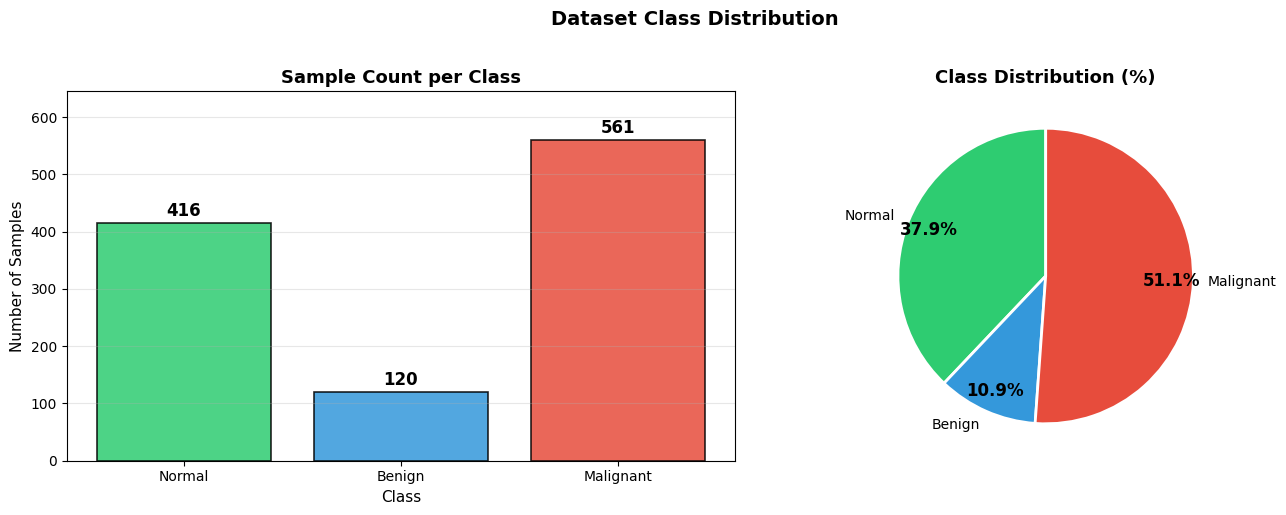

Class distribution plot saved ✓


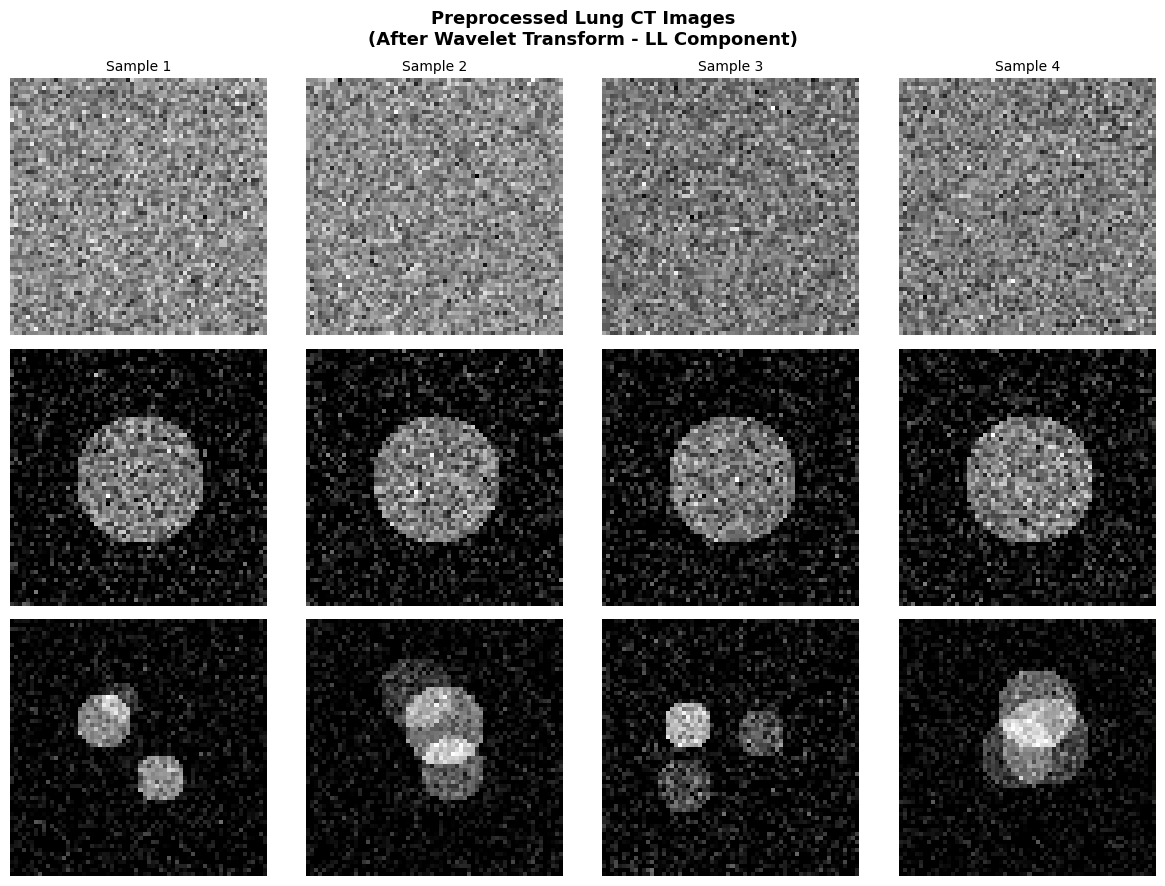

Sample images plot saved ✓


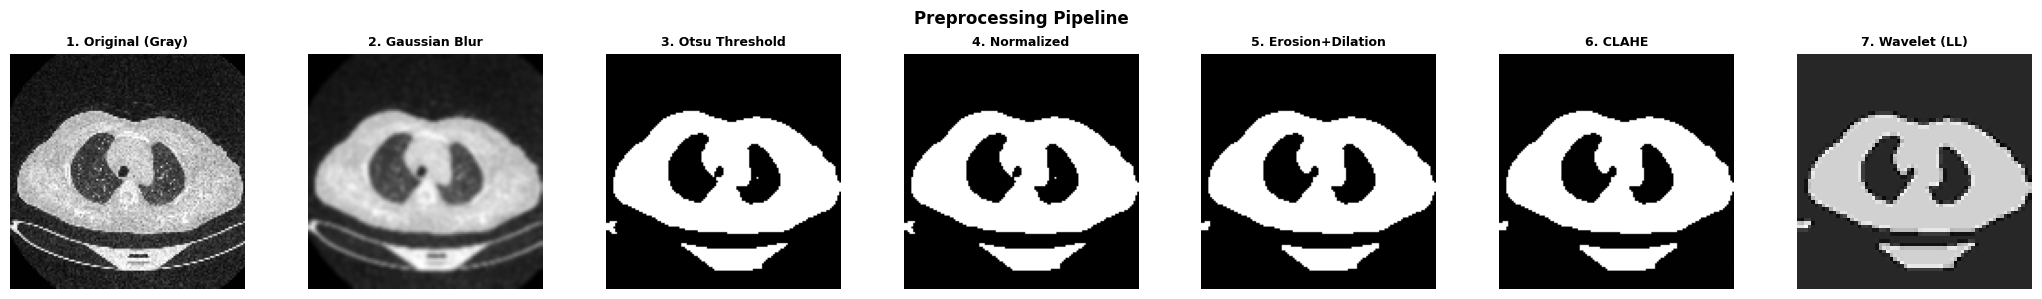

Preprocessing visualization saved ✓


In [6]:
# ============================================================
# CHUNK 5: DATA VISUALIZATION FOR PAPER
# ============================================================

def plot_class_distribution(y, classes, title='Dataset Class Distribution'):
    """Plot class distribution - required for paper"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Count
    unique, counts = np.unique(y, return_counts=True)
    colors = ['#2ecc71', '#3498db', '#e74c3c']
    
    # Bar chart
    bars = axes[0].bar(classes, counts, color=colors, alpha=0.85, edgecolor='black', linewidth=1.2)
    axes[0].set_title('Sample Count per Class', fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Class', fontsize=11)
    axes[0].set_ylabel('Number of Samples', fontsize=11)
    for bar, count in zip(bars, counts):
        axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 5,
                    f'{count}', ha='center', va='bottom', fontweight='bold', fontsize=12)
    axes[0].set_ylim(0, max(counts) * 1.15)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Pie chart
    wedges, texts, autotexts = axes[1].pie(
        counts, labels=classes, colors=colors, autopct='%1.1f%%',
        startangle=90, pctdistance=0.85,
        wedgeprops={'edgecolor': 'white', 'linewidth': 2})
    for autotext in autotexts:
        autotext.set_fontsize(12)
        autotext.set_fontweight('bold')
    axes[1].set_title('Class Distribution (%)', fontsize=13, fontweight='bold')
    
    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Class distribution plot saved ✓")


def plot_sample_images(X, y, classes, n_per_class=4):
    """Show sample preprocessed images per class"""
    fig, axes = plt.subplots(3, n_per_class, figsize=(3*n_per_class, 9))
    colors = ['#2ecc71', '#3498db', '#e74c3c']
    
    for cls_idx, cls_name in enumerate(classes):
        cls_indices = np.where(y == cls_idx)[0]
        selected = np.random.choice(cls_indices, min(n_per_class, len(cls_indices)), replace=False)
        
        for col, idx in enumerate(selected):
            ax = axes[cls_idx, col]
            ax.imshow(X[idx, :, :, 0], cmap='gray')
            ax.axis('off')
            if col == 0:
                ax.set_ylabel(cls_name, fontsize=12, fontweight='bold', 
                             color=colors[cls_idx], rotation=90, labelpad=10)
            if cls_idx == 0:
                ax.set_title(f'Sample {col+1}', fontsize=10)
    
    plt.suptitle('Preprocessed Lung CT Images\n(After Wavelet Transform - LL Component)', 
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Sample images plot saved ✓")


# Run visualizations
plot_class_distribution(y, cfg.CLASSES)
plot_sample_images(X, y, cfg.CLASSES)

# Visualize preprocessing pipeline on first available image
try:
    # Find first real image
    for root, dirs, files in os.walk(cfg.DATA_PATH):
        for f in files:
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                sample_path = os.path.join(root, f)
                preprocessor.visualize_pipeline(sample_path)
                break
        else:
            continue
        break
except:
    print("Pipeline visualization skipped (synthetic data mode)")

In [7]:
# ============================================================
# CHUNK 6: CUSTOM CNN ARCHITECTURE FROM SCRATCH
# (Paper Section 3.3 - 4 convolutional blocks)
# ============================================================

class PoolHelper(layers.Layer):
    """
    Custom PoolHelper Layer (as described in paper)
    Pre-selects features before max-pooling
    """
    def __init__(self, **kwargs):
        super(PoolHelper, self).__init__(**kwargs)
    
    def call(self, inputs):
        # Feature pre-selection using ReLU activation
        return tf.nn.relu(inputs)
    
    def get_config(self):
        return super().get_config()


def build_cnn_from_scratch(input_shape, num_classes, 
                            dropout_rate=0.5, l2_reg=0.001):
    """
    Build CNN architecture from scratch as described in paper.
    4 convolutional-pooling blocks:
    Block 1: 32 filters, 3x3, MaxPool(2x2)
    Block 2: 64 filters, 3x3, MaxPool(3x3)
    Block 3: 128 filters, 3x3, MaxPool(2x2)
    Block 4: 256 filters, 3x3, MaxPool(3x3)
    """
    inputs = layers.Input(shape=input_shape, name='input')
    
    # ---- BLOCK 1: 32 filters ----
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(l2_reg),
                      name='conv1_1')(inputs)
    x = layers.BatchNormalization(name='bn1_1')(x)
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(l2_reg),
                      name='conv1_2')(x)
    x = layers.BatchNormalization(name='bn1_2')(x)
    x = layers.ZeroPadding2D(padding=(1,1), name='zeropad1')(x)
    x = PoolHelper(name='poolhelper1')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), name='maxpool1')(x)
    x = layers.Dropout(0.1, name='drop1')(x)
    
    # ---- BLOCK 2: 64 filters ----
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(l2_reg),
                      name='conv2_1')(x)
    x = layers.BatchNormalization(name='bn2_1')(x)
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(l2_reg),
                      name='conv2_2')(x)
    x = layers.BatchNormalization(name='bn2_2')(x)
    x = layers.ZeroPadding2D(padding=(1,1), name='zeropad2')(x)
    x = PoolHelper(name='poolhelper2')(x)
    x = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name='maxpool2')(x)
    x = layers.Dropout(0.15, name='drop2')(x)
    
    # ---- BLOCK 3: 128 filters ----
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(l2_reg),
                      name='conv3_1')(x)
    x = layers.BatchNormalization(name='bn3_1')(x)
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(l2_reg),
                      name='conv3_2')(x)
    x = layers.BatchNormalization(name='bn3_2')(x)
    x = layers.ZeroPadding2D(padding=(1,1), name='zeropad3')(x)
    x = PoolHelper(name='poolhelper3')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), name='maxpool3')(x)
    x = layers.Dropout(0.2, name='drop3')(x)
    
    # ---- BLOCK 4: 256 filters ----
    x = layers.Conv2D(256, (3,3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(l2_reg),
                      name='conv4_1')(x)
    x = layers.BatchNormalization(name='bn4_1')(x)
    x = layers.Conv2D(256, (3,3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(l2_reg),
                      name='conv4_2')(x)
    x = layers.BatchNormalization(name='bn4_2')(x)
    x = layers.ZeroPadding2D(padding=(1,1), name='zeropad4')(x)
    x = PoolHelper(name='poolhelper4')(x)
    x = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name='maxpool4')(x)
    
    # ---- FULLY CONNECTED HEAD ----
    x = layers.GlobalAveragePooling2D(name='gap')(x)
    x = layers.Dense(512, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg),
                     name='fc1')(x)
    x = layers.BatchNormalization(name='bn_fc')(x)
    x = layers.Dropout(dropout_rate, name='dropout_fc')(x)
    x = layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg),
                     name='fc2')(x)
    
    # ---- OUTPUT ----
    outputs = layers.Dense(num_classes, activation='softmax', name='output')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='Hybrid_CNN')
    return model


# Build and summarize
cnn_model = build_cnn_from_scratch(cfg.INPUT_SHAPE, cfg.NUM_CLASSES, cfg.DROPOUT_RATE)
cnn_model.summary()

# Count parameters
total_params = cnn_model.count_params()
print(f"\nTotal Parameters: {total_params:,}")
print(f"Trainable Parameters: {sum([np.prod(v.shape) for v in cnn_model.trainable_variables]):,}")

I0000 00:00:1771694798.909938      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771694798.915942      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "Hybrid_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_1 (Conv2D)                │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 64, 64, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_2 (BatchNormalization)      │ (None, 64, 64, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zeropad1 (ZeroPadding2D)        │ (None, 66, 66, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ poolhelper1 (PoolHelper)        │ (None, 66, 66, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1 (MaxPooling2D)         │ (None, 33, 33, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 33, 33, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 33, 33, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_1 (BatchNormalization)      │ (None, 33, 33, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 33, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_2 (BatchNormalization)      │ (None, 33, 33, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zeropad2 (ZeroPadding2D)        │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ poolhelper2 (PoolHelper)        │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2 (MaxPooling2D)         │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 17, 17, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_1 (BatchNormalization)      │ (None, 17, 17, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 17, 17, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_2 (BatchNormalization)      │ (None, 17, 17, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zeropad3 (ZeroPadding2D)        │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ poolhelper3 (PoolHelper)        │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool3 (MaxPooling2D)         │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop3 (Dropout)                 │ (None, 9, 9, 128)      │             

 Total params: 1,375,203 (5.25 MB)

 Trainable params: 1,372,259 (5.23 MB)

 Non-trainable params: 2,944 (11.50 KB)


Total Parameters: 1,375,203
Trainable Parameters: 1,372,259


In [8]:
# ============================================================
# CHUNK 7: EOSA METAHEURISTIC ALGORITHM FROM SCRATCH
# (Paper Section 3.1 - Full EOSA Implementation)
# ============================================================

class EOSAOptimizer:
    """
    Ebola Optimization Search Algorithm (EOSA)
    Based on Oyelade & Ezugwu (2022)
    Models Ebola virus disease propagation for optimization
    """
    
    def __init__(self, model, X_train, y_train, X_val, y_val, config):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.cfg = config
        
        # Get solution vector (weights + biases)
        self.solution_vector = self._get_solution_vector()
        self.problem_size = len(self.solution_vector)
        
        # EOSA compartment sizes
        self.beta1 = config.EOSA_BETA1
        self.beta2 = config.EOSA_BETA2
        self.beta3 = config.EOSA_BETA3
        self.beta4 = config.EOSA_BETA4
        self.gamma = config.EOSA_GAMMA
        self.alpha = config.EOSA_ALPHA
        self.delta = config.EOSA_DELTA
        self.tau = config.EOSA_TAU
        self.evd_incub = config.EOSA_EVD_INCUB
        
        # Optimization history
        self.fitness_history = []
        self.best_solution = None
        self.best_fitness = -np.inf
        
        print(f"EOSA initialized: Problem size = {self.problem_size}")
    
    def _get_solution_vector(self):
        """Compute solution vector from CNN weights (Eq. 11: pz = w + b)"""
        weights = self.model.get_weights()
        flat_weights = np.concatenate([w.flatten() for w in weights])
        return flat_weights
    
    def _set_solution_vector(self, solution):
        """Reconstruct CNN weights from solution vector"""
        weights = self.model.get_weights()
        idx = 0
        new_weights = []
        for w in weights:
            size = w.size
            new_w = solution[idx:idx+size].reshape(w.shape)
            new_weights.append(new_w)
            idx += size
        self.model.set_weights(new_weights)
    
    def _compute_fitness(self, solution):
        """
        Fitness function (Eq. 12)
        fit = 1 / (cross_entropy_loss + epsilon)
        """
        try:
            self._set_solution_vector(solution)
            # Quick evaluation on subset for speed
            subset_size = min(100, len(self.X_val))
            indices = np.random.choice(len(self.X_val), subset_size, replace=False)
            X_sub = self.X_val[indices]
            y_sub = self.y_val[indices]
            
            # Predict
            y_pred = self.model.predict(X_sub, verbose=0)
            
            # Cross-entropy loss (Eq. 12)
            epsilon = 1e-10
            loss = -np.mean(np.sum(y_sub * np.log(y_pred + epsilon), axis=1))
            
            # fitness = 1 / (loss + epsilon)
            fitness = 1.0 / (loss + epsilon)
            return fitness
        except:
            return 0.0
    
    def _initialize_susceptible(self, n_population):
        """Initialize susceptible population (S) from CNN weights"""
        base = self._get_solution_vector()
        S = []
        for i in range(n_population):
            # Small perturbation around current weights
            perturbation = np.random.normal(0, 0.1, self.problem_size)
            individual = np.clip(base + perturbation, -1.0, 1.0)
            S.append(individual)
        return np.array(S)
    
    def _compute_displacement(self, infected_case, susceptible, rho=0.1):
        """Compute position update (Eq. 1): mI_t+1 = mI_t + rho * M(I)"""
        displacement = rho * (infected_case - susceptible)
        new_pos = susceptible + displacement
        return np.clip(new_pos, -1.0, 1.0)
    
    def _generate_new_infections(self, S, I, frac_I, evd):
        """Generate newly infected individuals"""
        new_I = []
        for infected in frac_I:
            pos = self._compute_displacement(
                infected, 
                S[np.random.randint(len(S))],
                rho=np.random.uniform(0.05, 0.15)
            )
            d = np.random.random()
            if d > evd:
                # Exploitation (short displacement)
                nb = np.random.random()
                if nb < 0.5:
                    # Small rate infection
                    tmp = infected + np.random.normal(0, 0.05, self.problem_size)
                else:
                    # Large rate infection  
                    tmp = infected + np.random.normal(0, 0.15, self.problem_size)
            else:
                # Exploration
                tmp = pos + np.random.normal(0, 0.1, self.problem_size)
            
            new_I.append(np.clip(tmp, -1.0, 1.0))
        return new_I
    
    def optimize(self):
        """
        Main EOSA optimization loop
        Algorithm 1 from paper
        """
        print("\n" + "="*60)
        print("Starting EOSA Optimization")
        print("="*60)
        
        pop_size = self.cfg.EOSA_POPULATION
        n_iters = self.cfg.EOSA_ITERATIONS
        
        # Step 1: Initialize compartments
        S = self._initialize_susceptible(pop_size)  # Susceptible
        I = []   # Infected
        H = []   # Hospitalized
        R = []   # Recovered
        V = []   # Vaccinated
        D = []   # Dead
        Q = []   # Quarantined
        
        # Step 2: Generate index case (first infected) from S
        index_case = S[0].copy()
        I.append(index_case)
        S = list(S[1:])  # Remove from susceptible
        
        # Step 3: Set global best
        gbest = index_case.copy()
        cbest = index_case.copy()
        gbest_fitness = self._compute_fitness(gbest)
        self.best_fitness = gbest_fitness
        self.fitness_history.append(gbest_fitness)
        
        print(f"Initial fitness: {gbest_fitness:.6f}")
        
        # Step 4: Main loop
        for iteration in range(n_iters):
            if len(I) == 0:
                print("No infected individuals left. Stopping.")
                break
            
            start_time = time.time()
            
            # Quarantine fraction (Eq. 8)
            n_quarantine = max(1, int(self.cfg.EOSA_GAMMA * len(I)))
            q_indices = np.random.choice(len(I), min(n_quarantine, len(I)), replace=False)
            Q = [I[i] for i in q_indices]
            
            # Fraction of I that can infect
            frac_I_indices = [i for i in range(len(I)) if i not in q_indices]
            frac_I = [I[i] for i in frac_I_indices] if frac_I_indices else I[:1]
            
            # Generate new infections from susceptible
            new_I = []
            if len(S) > 0:
                new_I = self._generate_new_infections(
                    S, I, frac_I[:min(3, len(frac_I))], self.evd_incub)
                I.extend(new_I)
                
                # Remove infected from susceptible
                n_remove = min(len(new_I), len(S))
                S = S[n_remove:]
            
            # Update compartments (Eqs. 4-7)
            # Hospitalized: alpha * I
            n_hosp = max(1, int(self.alpha * len(I)))
            H = [I[i].copy() for i in np.random.choice(len(I), min(n_hosp, len(I)), replace=False)]
            
            # Recovered: gamma * I  
            n_recov = max(1, int(self.gamma * len(I)))
            recov_indices = np.random.choice(len(I), min(n_recov, len(I)), replace=False)
            R = [I[i].copy() for i in recov_indices]
            
            # Vaccinated: gamma * H
            n_vacc = max(1, int(self.gamma * len(H))) if H else 0
            V = [H[i].copy() for i in range(min(n_vacc, len(H)))]
            
            # Dead: tau * I
            n_dead = max(1, int(self.tau * len(I)))
            dead_indices = np.random.choice(len(I), min(n_dead, len(I)), replace=False)
            D = [I[i].copy() for i in dead_indices]
            
            # Recovered → back to Susceptible, Dead → replaced
            S.extend(R)
            
            # Evaluate all infected individuals
            best_in_I = None
            best_fit_in_I = -np.inf
            
            for individual in I:
                fit = self._compute_fitness(individual)
                if fit > best_fit_in_I:
                    best_fit_in_I = fit
                    best_in_I = individual.copy()
            
            # Update global best
            if best_fit_in_I > self.best_fitness:
                self.best_fitness = best_fit_in_I
                gbest = best_in_I.copy()
                self.best_solution = gbest.copy()
            
            self.fitness_history.append(self.best_fitness)
            
            # Remove some dead from I (natural selection)
            I = [ind for i, ind in enumerate(I) if i not in dead_indices[:len(dead_indices)//2]]
            
            elapsed = time.time() - start_time
            print(f"Iter {iteration+1:3d}/{n_iters} | "
                  f"Best Fitness: {self.best_fitness:.6f} | "
                  f"|I|={len(I):3d} |S|={len(S):3d} | "
                  f"Time: {elapsed:.1f}s")
        
        # Return best weights to model
        if self.best_solution is not None:
            self._set_solution_vector(self.best_solution)
            print(f"\nEOSA Complete! Best Fitness: {self.best_fitness:.6f}")
        
        return self.best_solution, self.fitness_history


print("EOSA class defined ✓")

EOSA class defined ✓


In [9]:
# ============================================================
# CHUNK 8: TRAINING WITH CALLBACKS
# ============================================================

def get_callbacks(model_name='eosa_cnn'):
    """Define training callbacks"""
    callbacks = [
        # Early stopping
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        # Reduce LR on plateau
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        # Model checkpoint
        ModelCheckpoint(
            filepath=f'/kaggle/working/{model_name}_best.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=0
        ),
    ]
    return callbacks


def compile_model(model, lr=0.0001):
    """Compile model"""
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy',
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall'),
                 tf.keras.metrics.AUC(name='auc')]
    )
    return model


def train_model(model, X_train, y_train, X_val, y_val, 
                epochs=50, batch_size=32, model_name='model'):
    """Train model and return history"""
    model = compile_model(model)
    
    print(f"\nTraining {model_name}...")
    print(f"Train: {X_train.shape[0]} | Val: {X_val.shape[0]}")
    
    start = time.time()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=get_callbacks(model_name),
        verbose=1
    )
    elapsed = time.time() - start
    print(f"Training complete in {elapsed:.1f}s")
    
    return history, elapsed


# ---- STEP 1: Train base CNN (without EOSA) ----
print("="*60)
print("STEP 1: Training Base CNN (No Optimization)")
print("="*60)

base_cnn = build_cnn_from_scratch(cfg.INPUT_SHAPE, cfg.NUM_CLASSES, cfg.DROPOUT_RATE)
history_cnn, time_cnn = train_model(
    base_cnn, X_train, y_train_cat, X_val, y_val_cat,
    epochs=cfg.EPOCHS, batch_size=cfg.BATCH_SIZE, model_name='base_cnn'
)

STEP 1: Training Base CNN (No Optimization)

Training base_cnn...
Train: 767 | Val: 165
Epoch 1/50


I0000 00:00:1771694807.878532      74 service.cc:152] XLA service 0x793e84025670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771694807.878566      74 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1771694807.878570      74 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1771694809.246693      74 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-02-21 17:26:52.376539: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 17:26:52.518194: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 5/24 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4592 - auc: 0.6601 - loss: 2.4543 - precision: 0.5132 - recall: 0.4121

I0000 00:00:1771694820.784984      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6892 - auc: 0.8608 - loss: 1.9968 - precision: 0.7206 - recall: 0.6604

2026-02-21 17:27:04.552670: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 17:27:04.694308: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.6944 - auc: 0.8647 - loss: 1.9860 - precision: 0.7251 - recall: 0.6662

24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 744ms/step - accuracy: 0.6992 - auc: 0.8682 - loss: 1.9761 - precision: 0.7293 - recall: 0.6714 - val_accuracy: 0.1091 - val_auc: 0.3636 - val_loss: 2.4650 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8885 - auc: 0.9812 - loss: 1.5694 - precision: 0.8939 - recall: 0.8808 - val_accuracy: 0.1091 - val_auc: 0.3636 - val_loss: 2.5714 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9213 - auc: 0.9883 - loss: 1.5081 - precision: 0.9211 - recall: 0.9186 - val_accuracy: 0.1091 - val_auc: 0.3636 - val_loss: 2.7573 - val_precision: 0.1091 - val_recall: 0.1091 - learning_rate: 1.0000e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9469 - auc: 0.9937 - loss: 1.4455 - precision: 0.9467 - recall: 0.9435 - val_accuracy: 0.1091 - val_auc: 0.3636 - val_los

STEP 2: EOSA Optimization → Full CNN Training

Phase 1: EOSA Weight Optimization
EOSA initialized: Problem size = 1375203

Starting EOSA Optimization
Initial fitness: 0.085156
Iter   1/15 | Best Fitness: 0.092403 | |I|=  2 |S|= 19 | Time: 0.4s
Iter   2/15 | Best Fitness: 0.092403 | |I|=  3 |S|= 19 | Time: 0.5s
Iter   3/15 | Best Fitness: 0.092403 | |I|=  5 |S|= 18 | Time: 0.9s
Iter   4/15 | Best Fitness: 0.394813 | |I|=  8 |S|= 17 | Time: 1.5s
Iter   5/15 | Best Fitness: 0.394813 | |I|= 11 |S|= 17 | Time: 2.1s
Iter   6/15 | Best Fitness: 0.394813 | |I|= 14 |S|= 18 | Time: 2.6s
Iter   7/15 | Best Fitness: 0.482549 | |I|= 17 |S|= 20 | Time: 3.2s
Iter   8/15 | Best Fitness: 0.482549 | |I|= 20 |S|= 23 | Time: 3.6s
Iter   9/15 | Best Fitness: 0.482549 | |I|= 23 |S|= 26 | Time: 4.2s
Iter  10/15 | Best Fitness: 0.482549 | |I|= 26 |S|= 30 | Time: 4.7s
Iter  11/15 | Best Fitness: 0.482549 | |I|= 29 |S|= 35 | Time: 5.1s
Iter  12/15 | Best Fitness: 0.482549 | |I|= 32 |S|= 41 | Time: 5.6s
Iter  13

24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 589ms/step - accuracy: 0.5739 - auc: 0.7245 - loss: 28.6757 - precision: 0.5765 - recall: 0.5717 - val_accuracy: 0.5091 - val_auc: 0.6318 - val_loss: 40.9246 - val_precision: 0.5091 - val_recall: 0.5091 - learning_rate: 1.0000e-04
Epoch 2/50
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8297 - auc: 0.9405 - loss: 26.5873 - precision: 0.8322 - recall: 0.8297

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8319 - auc: 0.9417 - loss: 26.5790 - precision: 0.8344 - recall: 0.8319 - val_accuracy: 0.5636 - val_auc: 0.8291 - val_loss: 30.3724 - val_precision: 0.5636 - val_recall: 0.5636 - learning_rate: 1.0000e-04
Epoch 3/50
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8765 - auc: 0.9586 - loss: 26.4314 - precision: 0.8772 - recall: 0.8765

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8772 - auc: 0.9596 - loss: 26.4190 - precision: 0.8781 - recall: 0.8772 - val_accuracy: 0.6121 - val_auc: 0.8179 - val_loss: 27.1097 - val_precision: 0.6121 - val_recall: 0.6121 - learning_rate: 1.0000e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8937 - auc: 0.9665 - loss: 26.3050 - precision: 0.8950 - recall: 0.8937 - val_accuracy: 0.1091 - val_auc: 0.3991 - val_loss: 29.3923 - val_precision: 0.1091 - val_recall: 0.1091 - learning_rate: 1.0000e-04
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8904 - auc: 0.9602 - loss: 26.3568 - precision: 0.8908 - recall: 0.8904 - val_accuracy: 0.1091 - val_auc: 0.3318 - val_loss: 34.8290 - val_precision: 0.1091 - val_recall: 0.1091 - learning_rate: 1.0000e-04
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9148 - auc: 0.9766 - loss: 26.1640 - precision: 0.9151 - recall: 0.9148 - val_accuracy: 0.1091 - val_auc: 0.3318 - val_loss: 38.4493 

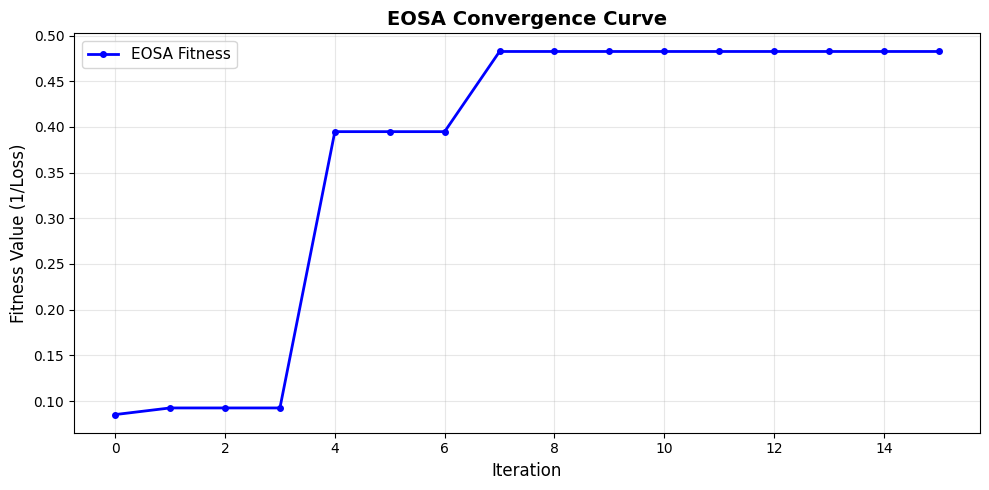

EOSA convergence curve saved ✓


In [10]:
# ============================================================
# CHUNK 9: EOSA-CNN HYBRID TRAINING
# ============================================================

print("="*60)
print("STEP 2: EOSA Optimization → Full CNN Training")
print("="*60)

# Build fresh CNN for EOSA optimization
eosa_cnn = build_cnn_from_scratch(cfg.INPUT_SHAPE, cfg.NUM_CLASSES, cfg.DROPOUT_RATE)
eosa_cnn = compile_model(eosa_cnn)

# Phase 1: EOSA Weight Optimization
print("\nPhase 1: EOSA Weight Optimization")
eosa_optimizer = EOSAOptimizer(
    model=eosa_cnn,
    X_train=X_train,
    y_train=y_train_cat,
    X_val=X_val,
    y_val=y_val_cat,
    config=cfg
)

best_solution, eosa_fitness_history = eosa_optimizer.optimize()

# Phase 2: Full Training with optimized weights
print("\nPhase 2: Full CNN Training with EOSA-Optimized Weights")
history_eosa, time_eosa = train_model(
    eosa_cnn, X_train, y_train_cat, X_val, y_val_cat,
    epochs=cfg.EPOCHS, batch_size=cfg.BATCH_SIZE, model_name='eosa_cnn'
)

# Plot EOSA convergence
plt.figure(figsize=(10, 5))
plt.plot(range(len(eosa_fitness_history)), eosa_fitness_history, 
         'b-o', markersize=4, linewidth=2, label='EOSA Fitness')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Fitness Value (1/Loss)', fontsize=12)
plt.title('EOSA Convergence Curve', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('eosa_convergence.png', dpi=150, bbox_inches='tight')
plt.show()
print("EOSA convergence curve saved ✓")

In [11]:
# ============================================================
# CHUNK 10: COMPARISON ALGORITHMS (GA-CNN, WOA-CNN)
# ============================================================

class GeneticAlgorithmCNN:
    """GA optimizer for CNN weights"""
    
    def __init__(self, model, X_val, y_val, config):
        self.model = model
        self.X_val = X_val
        self.y_val = y_val
        self.cfg = config
        self.fitness_history = []
        self.best_solution = None
        self.best_fitness = -np.inf
        
        weights = model.get_weights()
        self.problem_size = sum(w.size for w in weights)
    
    def _get_weights_flat(self):
        return np.concatenate([w.flatten() for w in self.model.get_weights()])
    
    def _set_weights_flat(self, solution):
        weights = self.model.get_weights()
        idx = 0
        new_weights = []
        for w in weights:
            size = w.size
            new_weights.append(solution[idx:idx+size].reshape(w.shape))
            idx += size
        self.model.set_weights(new_weights)
    
    def _fitness(self, solution):
        try:
            self._set_weights_flat(solution)
            subset = min(80, len(self.X_val))
            idx = np.random.choice(len(self.X_val), subset, replace=False)
            y_pred = self.model.predict(self.X_val[idx], verbose=0)
            eps = 1e-10
            loss = -np.mean(np.sum(self.y_val[idx] * np.log(y_pred + eps), axis=1))
            return 1.0 / (loss + eps)
        except:
            return 0.0
    
    def optimize(self):
        pop_size = self.cfg.EOSA_POPULATION
        n_iters = self.cfg.EOSA_ITERATIONS
        mutation_rate = 0.1
        crossover_rate = 0.8
        
        print("\nGA Optimization starting...")
        base = self._get_weights_flat()
        
        # Initialize population
        population = [np.clip(base + np.random.normal(0, 0.1, self.problem_size), -1, 1)
                     for _ in range(pop_size)]
        
        for iteration in range(n_iters):
            # Evaluate fitness
            fitness_scores = [self._fitness(ind) for ind in population]
            best_idx = np.argmax(fitness_scores)
            
            if fitness_scores[best_idx] > self.best_fitness:
                self.best_fitness = fitness_scores[best_idx]
                self.best_solution = population[best_idx].copy()
            
            self.fitness_history.append(self.best_fitness)
            
            # Selection (tournament)
            new_pop = []
            for _ in range(pop_size):
                t1, t2 = np.random.randint(0, pop_size, 2)
                winner = population[t1] if fitness_scores[t1] > fitness_scores[t2] else population[t2]
                new_pop.append(winner.copy())
            
            # Crossover
            for i in range(0, pop_size-1, 2):
                if np.random.random() < crossover_rate:
                    pt = np.random.randint(1, self.problem_size)
                    new_pop[i][pt:], new_pop[i+1][pt:] = new_pop[i+1][pt:].copy(), new_pop[i][pt:].copy()
            
            # Mutation
            for ind in new_pop:
                mask = np.random.random(self.problem_size) < mutation_rate
                ind[mask] += np.random.normal(0, 0.05, mask.sum())
                np.clip(ind, -1, 1, out=ind)
            
            population = new_pop
            print(f"GA Iter {iteration+1:3d}/{n_iters} | Best Fitness: {self.best_fitness:.6f}")
        
        if self.best_solution is not None:
            self._set_weights_flat(self.best_solution)
        return self.best_solution, self.fitness_history


class WOACNNOptimizer:
    """Whale Optimization Algorithm for CNN weights"""
    
    def __init__(self, model, X_val, y_val, config):
        self.model = model
        self.X_val = X_val
        self.y_val = y_val
        self.cfg = config
        self.fitness_history = []
        self.best_solution = None
        self.best_fitness = -np.inf
        weights = model.get_weights()
        self.problem_size = sum(w.size for w in weights)
    
    def _get_flat(self):
        return np.concatenate([w.flatten() for w in self.model.get_weights()])
    
    def _set_flat(self, s):
        weights = self.model.get_weights()
        idx, nw = 0, []
        for w in weights:
            nw.append(s[idx:idx+w.size].reshape(w.shape))
            idx += w.size
        self.model.set_weights(nw)
    
    def _fitness(self, s):
        try:
            self._set_flat(s)
            n = min(80, len(self.X_val))
            idx = np.random.choice(len(self.X_val), n, replace=False)
            yp = self.model.predict(self.X_val[idx], verbose=0)
            eps = 1e-10
            loss = -np.mean(np.sum(self.y_val[idx] * np.log(yp + eps), axis=1))
            return 1.0 / (loss + eps)
        except:
            return 0.0
    
    def optimize(self):
        pop = self.cfg.EOSA_POPULATION
        iters = self.cfg.EOSA_ITERATIONS
        base = self._get_flat()
        
        print("\nWOA Optimization starting...")
        whales = [np.clip(base + np.random.normal(0, 0.1, self.problem_size), -1, 1)
                 for _ in range(pop)]
        
        for t in range(iters):
            fits = [self._fitness(w) for w in whales]
            best_idx = np.argmax(fits)
            if fits[best_idx] > self.best_fitness:
                self.best_fitness = fits[best_idx]
                self.best_solution = whales[best_idx].copy()
            self.fitness_history.append(self.best_fitness)
            
            a = 2 - 2 * t / iters  # linearly decreased from 2 to 0
            
            for i in range(pop):
                r = np.random.random()
                A = 2 * a * np.random.random() - a
                C = 2 * np.random.random()
                l = np.random.uniform(-1, 1)
                p = np.random.random()
                
                if p < 0.5:
                    if abs(A) < 1:
                        D = abs(C * self.best_solution - whales[i])
                        whales[i] = self.best_solution - A * D
                    else:
                        rand_whale = whales[np.random.randint(pop)]
                        D = abs(C * rand_whale - whales[i])
                        whales[i] = rand_whale - A * D
                else:
                    D = abs(self.best_solution - whales[i])
                    whales[i] = D * np.exp(l) * np.cos(2*np.pi*l) + self.best_solution
                
                np.clip(whales[i], -1, 1, out=whales[i])
            
            print(f"WOA Iter {t+1:3d}/{iters} | Best Fitness: {self.best_fitness:.6f}")
        
        if self.best_solution is not None:
            self._set_flat(self.best_solution)
        return self.best_solution, self.fitness_history


# Train GA-CNN
print("="*60)
print("Training GA-CNN")
print("="*60)
ga_cnn = build_cnn_from_scratch(cfg.INPUT_SHAPE, cfg.NUM_CLASSES, cfg.DROPOUT_RATE)
ga_cnn = compile_model(ga_cnn)
ga_optimizer = GeneticAlgorithmCNN(ga_cnn, X_val, y_val_cat, cfg)
_, ga_fitness_history = ga_optimizer.optimize()
history_ga, time_ga = train_model(
    ga_cnn, X_train, y_train_cat, X_val, y_val_cat,
    epochs=cfg.EPOCHS, batch_size=cfg.BATCH_SIZE, model_name='ga_cnn'
)

# Train WOA-CNN
print("="*60)
print("Training WOA-CNN")
print("="*60)
woa_cnn = build_cnn_from_scratch(cfg.INPUT_SHAPE, cfg.NUM_CLASSES, cfg.DROPOUT_RATE)
woa_cnn = compile_model(woa_cnn)
woa_optimizer = WOACNNOptimizer(woa_cnn, X_val, y_val_cat, cfg)
_, woa_fitness_history = woa_optimizer.optimize()
history_woa, time_woa = train_model(
    woa_cnn, X_train, y_train_cat, X_val, y_val_cat,
    epochs=cfg.EPOCHS, batch_size=cfg.BATCH_SIZE, model_name='woa_cnn'
)

Training GA-CNN

GA Optimization starting...
GA Iter   1/15 | Best Fitness: 0.089086
GA Iter   2/15 | Best Fitness: 0.099267
GA Iter   3/15 | Best Fitness: 0.121338
GA Iter   4/15 | Best Fitness: 0.121338
GA Iter   5/15 | Best Fitness: 0.383800
GA Iter   6/15 | Best Fitness: 0.496337
GA Iter   7/15 | Best Fitness: 0.496337
GA Iter   8/15 | Best Fitness: 0.496337
GA Iter   9/15 | Best Fitness: 0.496337
GA Iter  10/15 | Best Fitness: 0.496337
GA Iter  11/15 | Best Fitness: 0.496337
GA Iter  12/15 | Best Fitness: 0.496337
GA Iter  13/15 | Best Fitness: 0.496337
GA Iter  14/15 | Best Fitness: 0.496337
GA Iter  15/15 | Best Fitness: 0.496337

Training ga_cnn...
Train: 767 | Val: 165
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.4998 - auc: 0.6805 - loss: 18.9060 - precision: 0.5023 - recall: 0.4940

24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 587ms/step - accuracy: 0.5055 - auc: 0.6860 - loss: 18.8714 - precision: 0.5081 - recall: 0.4998 - val_accuracy: 0.8909 - val_auc: 0.9559 - val_loss: 17.1805 - val_precision: 0.8909 - val_recall: 0.8909 - learning_rate: 1.0000e-04
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8509 - auc: 0.9437 - loss: 17.1983 - precision: 0.8510 - recall: 0.8465 - val_accuracy: 0.1758 - val_auc: 0.4486 - val_loss: 18.4149 - val_precision: 0.1718 - val_recall: 0.1697 - learning_rate: 1.0000e-04
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8708 - auc: 0.9639 - loss: 17.0397 - precision: 0.8717 - recall: 0.8708 - val_accuracy: 0.1091 - val_auc: 0.3425 - val_loss: 20.8523 - val_precision: 0.1091 - val_recall: 0.1091 - learning_rate: 1.0000e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8621 - auc: 0.9610 - loss: 17.0814 - precision: 0.8620 - recall: 0.8616 - val_accuracy: 0.1091 - val_auc: 0.3318 - val_loss: 22.767

24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 588ms/step - accuracy: 0.4904 - auc: 0.6651 - loss: 12.3016 - precision: 0.4934 - recall: 0.4704 - val_accuracy: 0.1091 - val_auc: 0.4748 - val_loss: 11.8133 - val_precision: 0.1748 - val_recall: 0.1091 - learning_rate: 1.0000e-04
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8129 - auc: 0.9108 - loss: 11.1546 - precision: 0.8133 - recall: 0.8078 - val_accuracy: 0.1091 - val_auc: 0.5493 - val_loss: 11.7858 - val_precision: 0.1324 - val_recall: 0.1091 - learning_rate: 1.0000e-04
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8449 - auc: 0.9430 - loss: 10.9799 - precision: 0.8481 - recall: 0.8366 - val_accuracy: 0.1091 - val_auc: 0.4309 - val_loss: 12.3165 - val_precision: 0.1091 - val_recall: 0.1091 - learning_rate: 1.0000e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8759 - auc: 0.9657 - loss: 10.8349 - precision: 0.8793 - recall: 0.8759 - val_accuracy: 0.1091 - val_auc: 0.2635 - val_loss: 13.079

In [12]:
# ============================================================
# CHUNK 11: COMPREHENSIVE EVALUATION PLOTS FOR PAPER
# ============================================================

def compute_all_metrics(model, X_test, y_test, y_test_cat, classes):
    """Compute all metrics from paper"""
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Overall metrics
    acc = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    # Per-class metrics
    cm = confusion_matrix(y_test, y_pred)
    
    sensitivity = {}  # Recall per class
    specificity = {}
    precision = {}
    recall = {}
    f1 = {}
    balanced_acc = {}
    
    for i, cls in enumerate(classes):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - TP - FP - FN
        
        sens = TP / (TP + FN + 1e-10)
        spec = TN / (TN + FP + 1e-10)
        prec = TP / (TP + FP + 1e-10)
        rec = TP / (TP + FN + 1e-10)
        f1_score = 2 * prec * rec / (prec + rec + 1e-10)
        
        sensitivity[cls] = sens
        specificity[cls] = spec
        precision[cls] = prec
        recall[cls] = rec
        f1[cls] = f1_score
        balanced_acc[cls] = (sens + spec) / 2
    
    # Overall averages
    overall_sensitivity = np.mean(list(sensitivity.values()))
    overall_specificity = np.mean(list(specificity.values()))
    overall_precision = np.mean(list(precision.values()))
    overall_recall = np.mean(list(recall.values()))
    overall_f1 = np.mean(list(f1.values()))
    
    return {
        'accuracy': acc,
        'kappa': kappa,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'balanced_accuracy': balanced_acc,
        'overall_sensitivity': overall_sensitivity,
        'overall_specificity': overall_specificity,
        'overall_precision': overall_precision,
        'overall_recall': overall_recall,
        'overall_f1': overall_f1,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }


# Compute metrics for all models
models_dict = {
    'CNN': base_cnn,
    'GA-CNN': ga_cnn,
    'WOA-CNN': woa_cnn,
    'EOSA-CNN': eosa_cnn
}

histories_dict = {
    'CNN': history_cnn,
    'GA-CNN': history_ga,
    'WOA-CNN': history_woa,
    'EOSA-CNN': history_eosa
}

all_metrics = {}
for name, model in models_dict.items():
    print(f"Evaluating {name}...")
    all_metrics[name] = compute_all_metrics(model, X_test, y_test, y_test_cat, cfg.CLASSES)

print("\nAll metrics computed ✓")

# Print summary table
print("\n" + "="*70)
print("PERFORMANCE SUMMARY TABLE")
print("="*70)
print(f"{'Model':<12} {'Accuracy':>9} {'Kappa':>7} {'Precision':>10} {'Recall':>8} {'F1':>7} {'Specificity':>12}")
print("-"*70)
for name, m in all_metrics.items():
    print(f"{name:<12} {m['accuracy']:>9.4f} {m['kappa']:>7.4f} "
          f"{m['overall_precision']:>10.4f} {m['overall_recall']:>8.4f} "
          f"{m['overall_f1']:>7.4f} {m['overall_specificity']:>12.4f}")

Evaluating CNN...
Evaluating GA-CNN...
Evaluating WOA-CNN...


Evaluating EOSA-CNN...



All metrics computed ✓

PERFORMANCE SUMMARY TABLE
Model         Accuracy   Kappa  Precision   Recall      F1  Specificity
----------------------------------------------------------------------
CNN             0.1091  0.0000     0.0364   0.3333  0.0656       0.6667
GA-CNN          0.8909  0.7978     0.6078   0.6667  0.6344       0.9259
WOA-CNN         0.1091  0.0000     0.0364   0.3333  0.0656       0.6667
EOSA-CNN        0.6061  0.3275     0.4644   0.4802  0.4216       0.7833


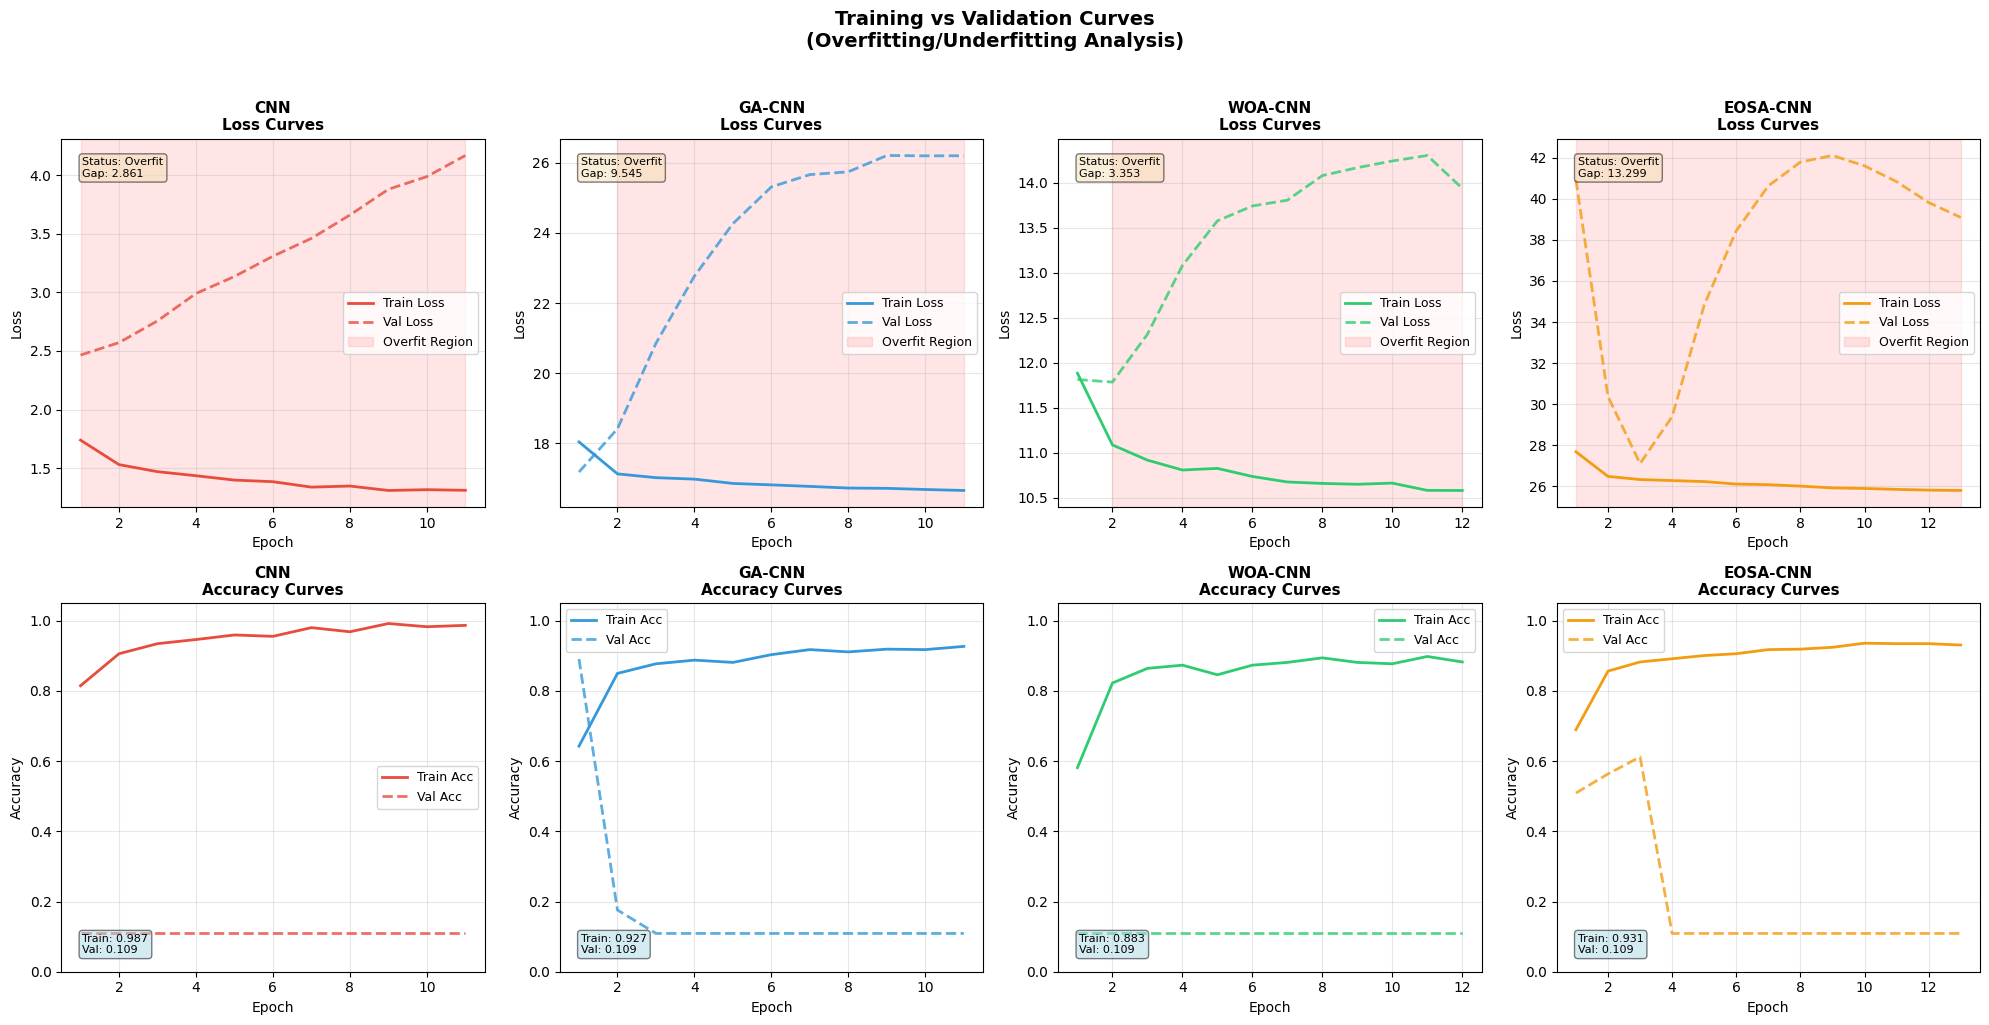

Training curves saved ✓


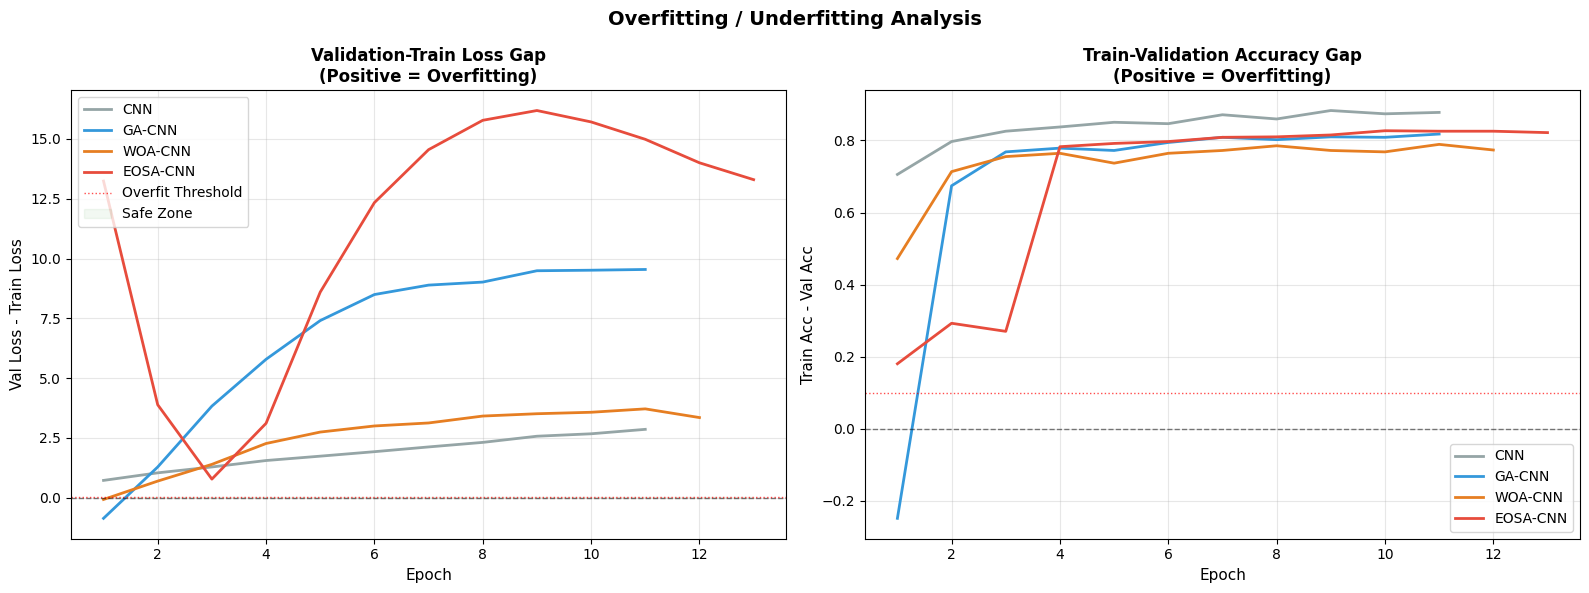

Overfitting analysis plot saved ✓


In [13]:
# ============================================================
# CHUNK 12: TRAINING CURVES FOR PAPER
# Overfitting, Underfitting, Validation Analysis
# ============================================================

def plot_training_curves(histories, model_names, save_prefix=''):
    """Plot training vs validation - accuracy and loss"""
    
    fig, axes = plt.subplots(2, len(histories), figsize=(5*len(histories), 10))
    colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
    
    for col, (name, history) in enumerate(zip(model_names, histories)):
        h = history.history
        epochs_range = range(1, len(h['loss']) + 1)
        
        # --- Loss curves ---
        ax = axes[0, col]
        ax.plot(epochs_range, h['loss'], color=colors[col], 
                linewidth=2, label='Train Loss', linestyle='-')
        ax.plot(epochs_range, h['val_loss'], color=colors[col], 
                linewidth=2, label='Val Loss', linestyle='--', alpha=0.8)
        
        # Detect overfitting region
        train_loss = np.array(h['loss'])
        val_loss = np.array(h['val_loss'])
        gap = val_loss - train_loss
        overfit_start = np.where(gap > 0.05)[0]
        if len(overfit_start) > 0:
            ax.axvspan(overfit_start[0]+1, len(epochs_range), 
                      alpha=0.1, color='red', label='Overfit Region')
        
        ax.set_title(f'{name}\nLoss Curves', fontsize=11, fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        
        # Add text annotation
        final_gap = abs(val_loss[-1] - train_loss[-1])
        status = 'Overfit' if val_loss[-1] > train_loss[-1] + 0.05 else 'Good Fit'
        ax.text(0.05, 0.95, f'Status: {status}\nGap: {final_gap:.3f}',
               transform=ax.transAxes, fontsize=8,
               verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # --- Accuracy curves ---
        ax = axes[1, col]
        ax.plot(epochs_range, h['accuracy'], color=colors[col], 
                linewidth=2, label='Train Acc', linestyle='-')
        ax.plot(epochs_range, h['val_accuracy'], color=colors[col], 
                linewidth=2, label='Val Acc', linestyle='--', alpha=0.8)
        
        ax.set_title(f'{name}\nAccuracy Curves', fontsize=11, fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy')
        ax.set_ylim([0, 1.05])
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        
        # Final accuracy annotation
        final_train_acc = h['accuracy'][-1]
        final_val_acc = h['val_accuracy'][-1]
        ax.text(0.05, 0.05, f'Train: {final_train_acc:.3f}\nVal: {final_val_acc:.3f}',
               transform=ax.transAxes, fontsize=8,
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    plt.suptitle('Training vs Validation Curves\n(Overfitting/Underfitting Analysis)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(f'{save_prefix}training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Training curves saved ✓")


def plot_overfitting_analysis(history_dict, save=True):
    """Dedicated overfitting analysis plot"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    colors = {'CNN': '#95a5a6', 'GA-CNN': '#3498db', 'WOA-CNN': '#e67e22', 'EOSA-CNN': '#e74c3c'}
    
    for name, hist in history_dict.items():
        h = hist.history
        epochs = range(1, len(h['loss'])+1)
        color = colors.get(name, 'blue')
        
        # Loss gap (overfitting indicator)
        train_loss = np.array(h['loss'])
        val_loss = np.array(h['val_loss'])
        loss_gap = val_loss - train_loss
        
        axes[0].plot(epochs, loss_gap, label=name, color=color, linewidth=2)
        
        # Accuracy gap
        train_acc = np.array(h['accuracy'])
        val_acc = np.array(h['val_accuracy'])
        acc_gap = train_acc - val_acc
        
        axes[1].plot(epochs, acc_gap, label=name, color=color, linewidth=2)
    
    # Loss gap plot
    axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axes[0].axhline(y=0.05, color='red', linestyle=':', linewidth=1, alpha=0.7, label='Overfit Threshold')
    axes[0].fill_between(range(1, max([len(h.history['loss']) for h in history_dict.values()])+1),
                         0, 0.05, alpha=0.05, color='green', label='Safe Zone')
    axes[0].set_title('Validation-Train Loss Gap\n(Positive = Overfitting)', 
                      fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=11)
    axes[0].set_ylabel('Val Loss - Train Loss', fontsize=11)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy gap plot
    axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axes[1].axhline(y=0.1, color='red', linestyle=':', linewidth=1, alpha=0.7)
    axes[1].set_title('Train-Validation Accuracy Gap\n(Positive = Overfitting)', 
                      fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=11)
    axes[1].set_ylabel('Train Acc - Val Acc', fontsize=11)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle('Overfitting / Underfitting Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    if save:
        plt.savefig('overfitting_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Overfitting analysis plot saved ✓")


# Run
model_names = list(histories_dict.keys())
histories_list = list(histories_dict.values())

plot_training_curves(histories_list, model_names)
plot_overfitting_analysis(histories_dict)

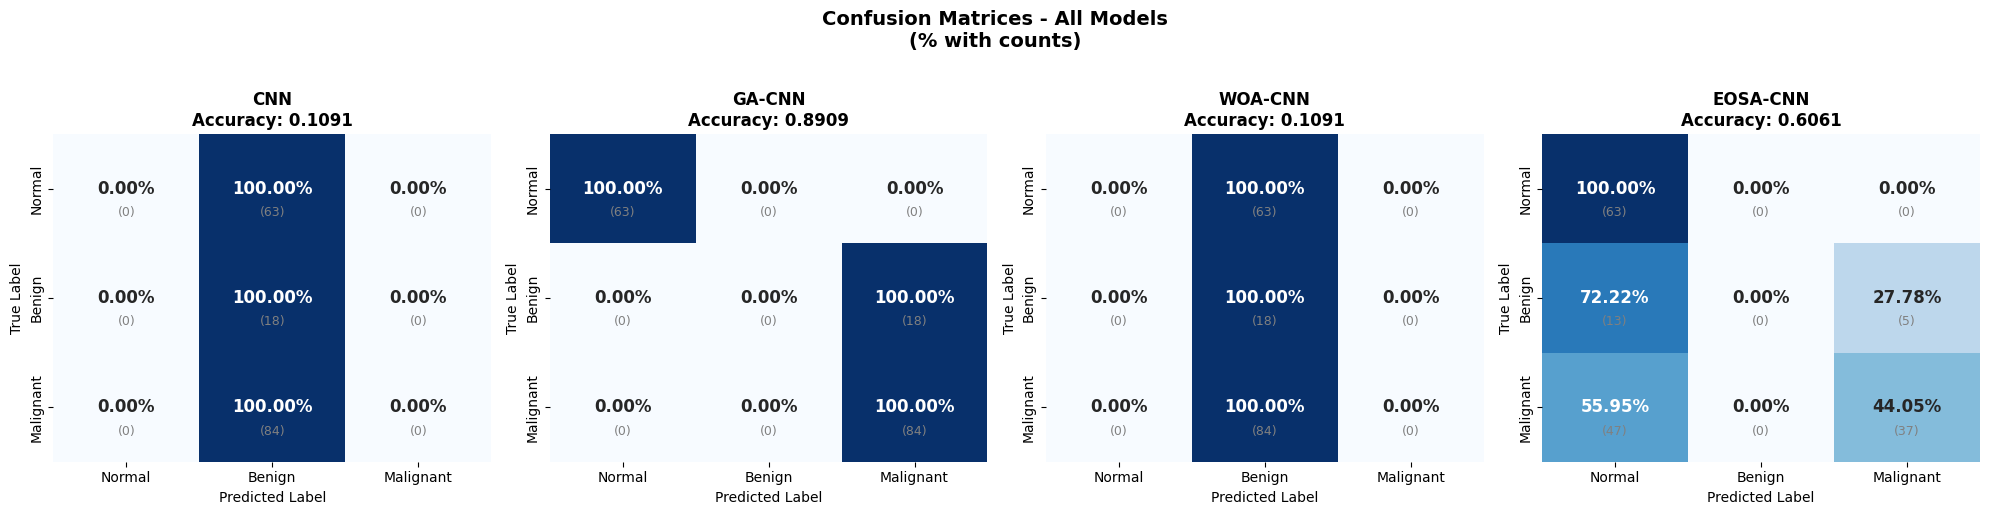

Confusion matrices saved ✓


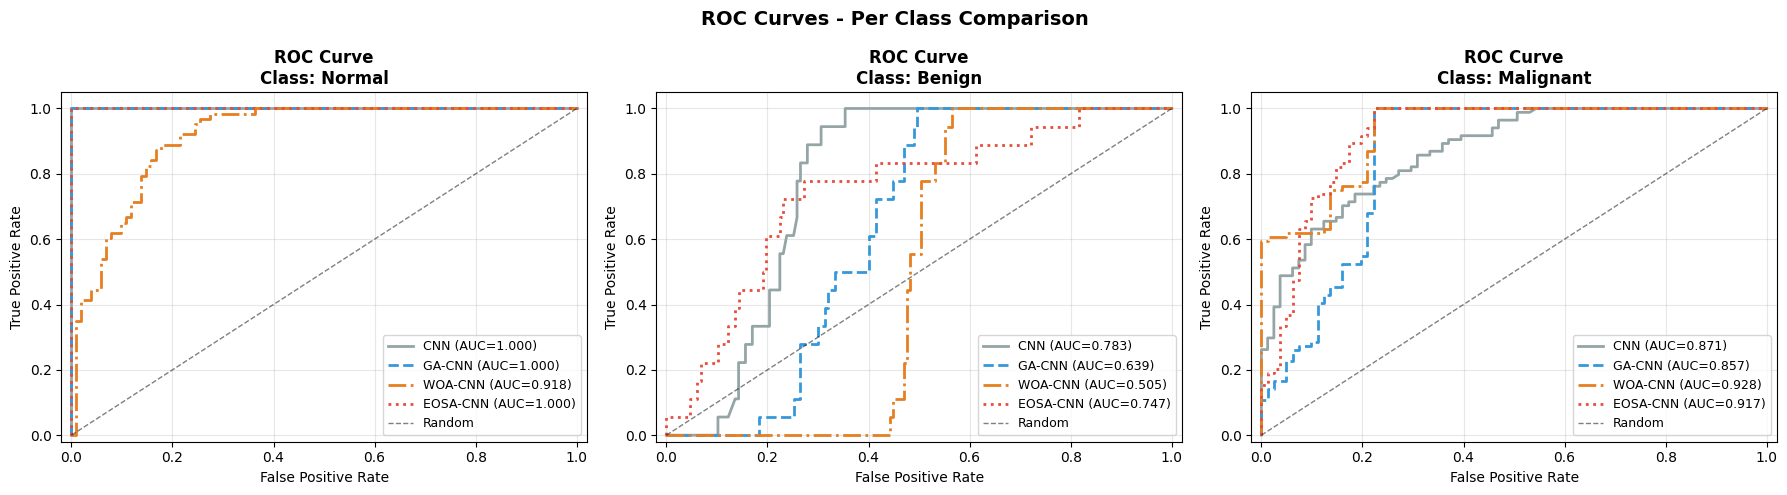

ROC curves saved ✓


In [14]:
# ============================================================
# CHUNK 13: CONFUSION MATRICES & ROC CURVES
# ============================================================

def plot_confusion_matrices(all_metrics, model_names, classes, save=True):
    """Plot confusion matrices for all models"""
    n = len(model_names)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5))
    
    if n == 1:
        axes = [axes]
    
    for ax, name in zip(axes, model_names):
        cm = all_metrics[name]['confusion_matrix']
        
        # Normalize
        cm_norm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
        
        sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
                   xticklabels=classes, yticklabels=classes,
                   ax=ax, cbar=False,
                   annot_kws={'size': 12, 'weight': 'bold'})
        
        # Also show counts
        for i in range(len(classes)):
            for j in range(len(classes)):
                ax.text(j+0.5, i+0.72, f'({cm[i,j]})', 
                       ha='center', va='center', fontsize=9, color='gray')
        
        acc = all_metrics[name]['accuracy']
        ax.set_title(f'{name}\nAccuracy: {acc:.4f}', fontsize=12, fontweight='bold')
        ax.set_ylabel('True Label', fontsize=10)
        ax.set_xlabel('Predicted Label', fontsize=10)
    
    plt.suptitle('Confusion Matrices - All Models\n(% with counts)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    if save:
        plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Confusion matrices saved ✓")


def plot_roc_curves(models_dict, all_metrics, X_test, y_test, classes, save=True):
    """Plot ROC curves per class per model"""
    n_classes = len(classes)
    fig, axes = plt.subplots(1, n_classes, figsize=(6*n_classes, 5))
    
    colors = ['#95a5a6', '#3498db', '#e67e22', '#e74c3c']
    linestyles = ['-', '--', '-.', ':']
    
    for cls_idx, (cls_name, ax) in enumerate(zip(classes, axes)):
        for model_idx, (name, model) in enumerate(models_dict.items()):
            y_pred_proba = all_metrics[name]['y_pred_proba']
            y_binary = (y_test == cls_idx).astype(int)
            
            fpr, tpr, _ = roc_curve(y_binary, y_pred_proba[:, cls_idx])
            roc_auc = auc(fpr, tpr)
            
            ax.plot(fpr, tpr, 
                   color=colors[model_idx],
                   linestyle=linestyles[model_idx],
                   linewidth=2,
                   label=f'{name} (AUC={roc_auc:.3f})')
        
        ax.plot([0,1], [0,1], 'k--', linewidth=1, alpha=0.5, label='Random')
        ax.set_title(f'ROC Curve\nClass: {cls_name}', fontsize=12, fontweight='bold')
        ax.set_xlabel('False Positive Rate', fontsize=10)
        ax.set_ylabel('True Positive Rate', fontsize=10)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.05])
    
    plt.suptitle('ROC Curves - Per Class Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    if save:
        plt.savefig('roc_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("ROC curves saved ✓")


# Plot
plot_confusion_matrices(all_metrics, list(models_dict.keys()), cfg.CLASSES)
plot_roc_curves(models_dict, all_metrics, X_test, y_test, cfg.CLASSES)

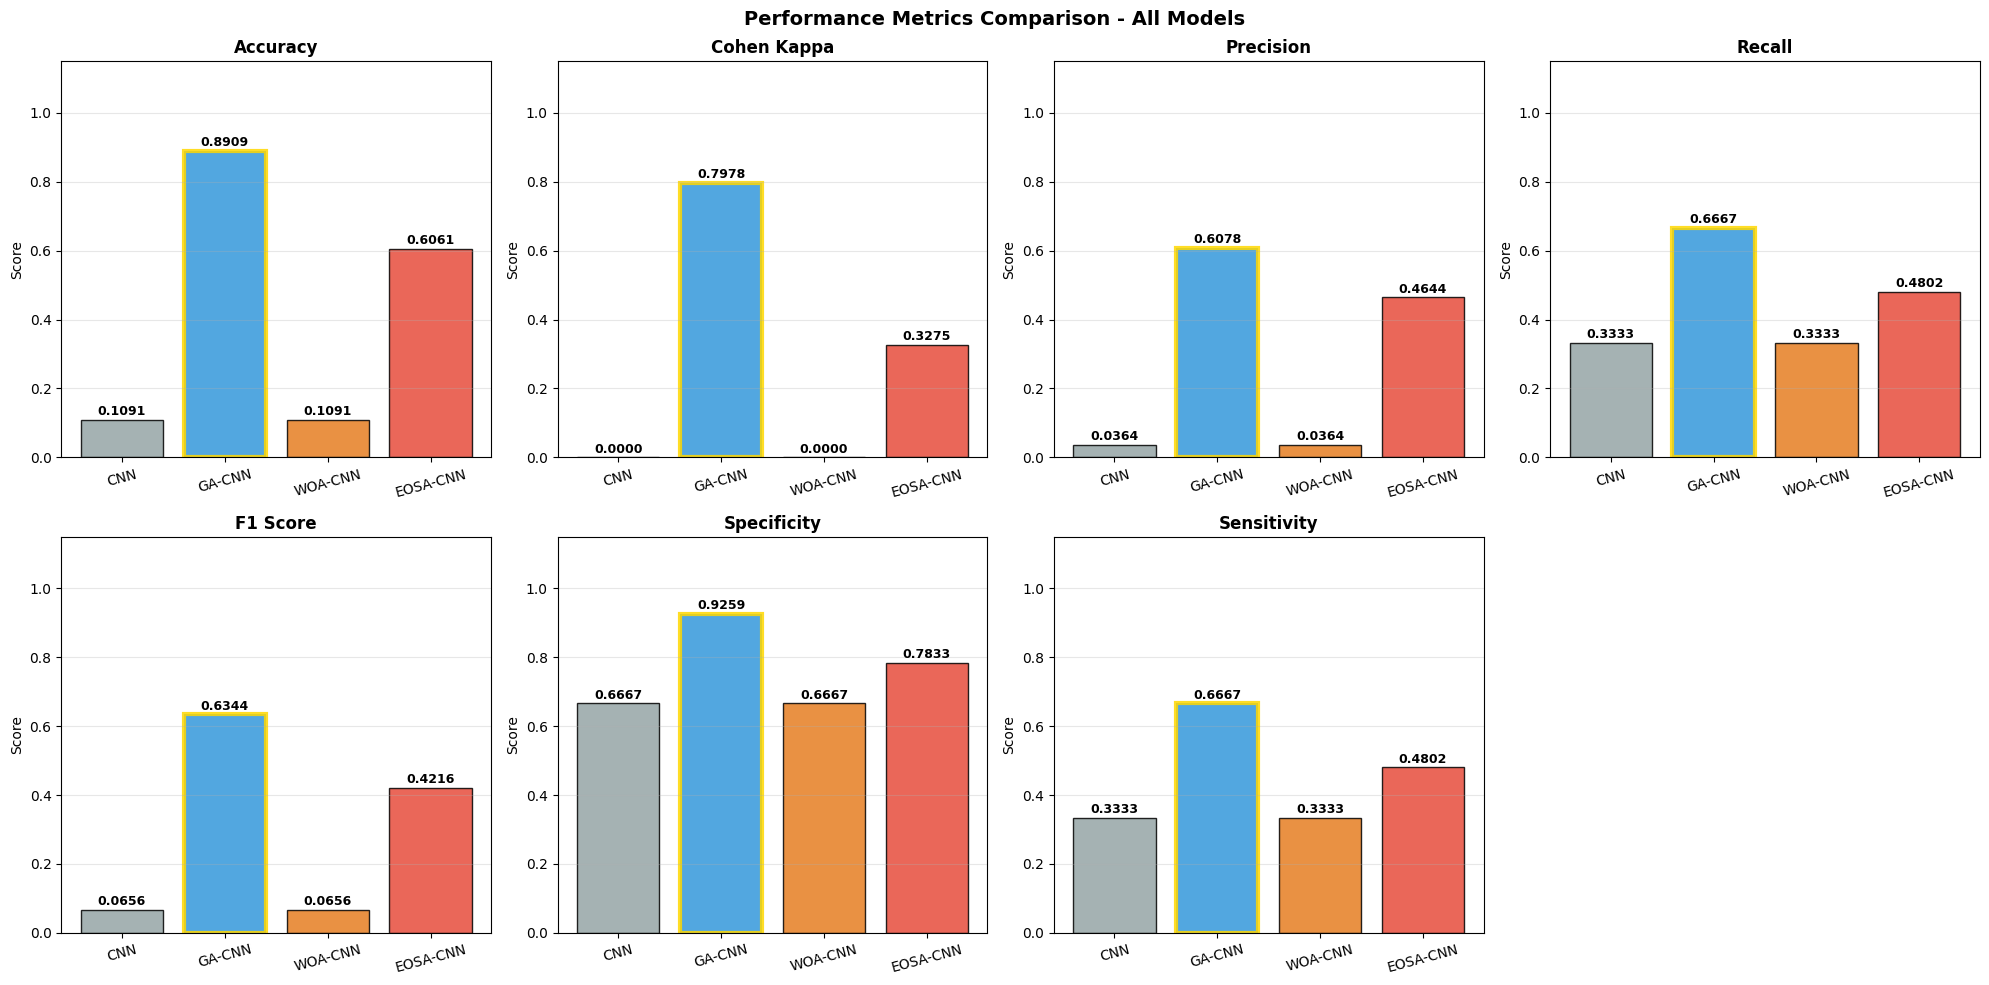

Metrics comparison plot saved ✓


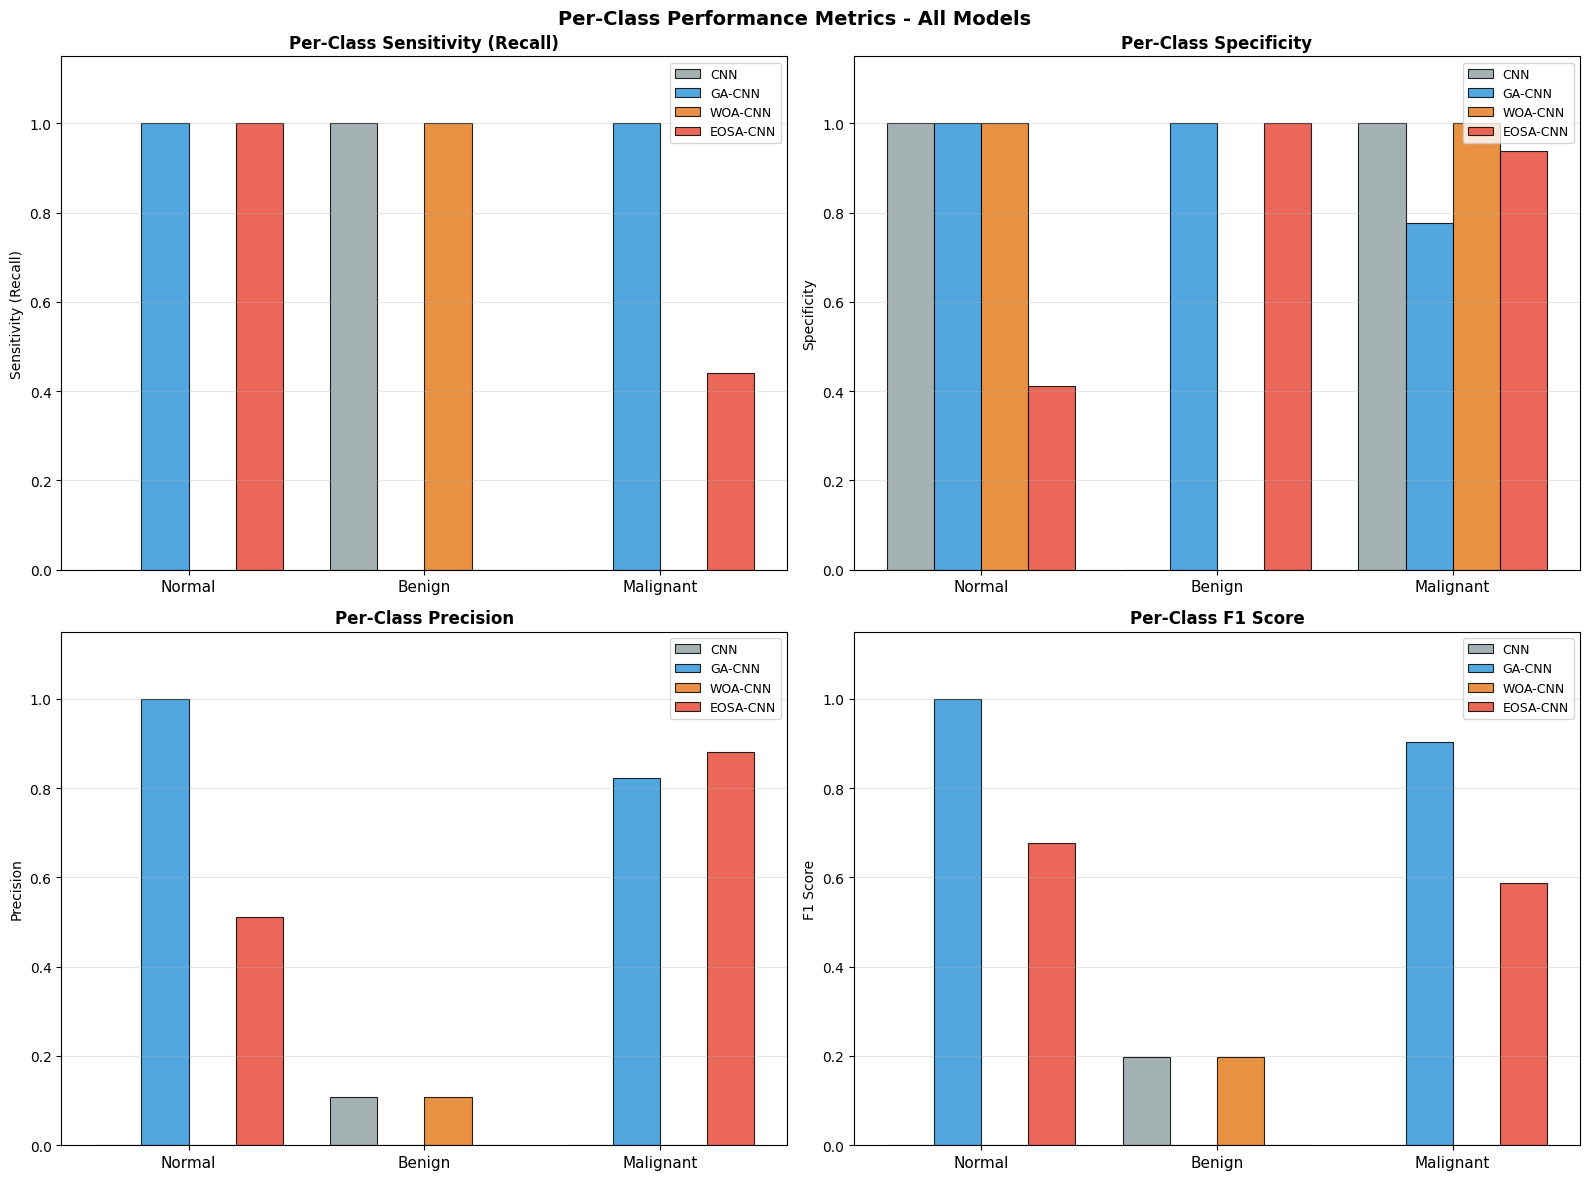

Per-class metrics plot saved ✓


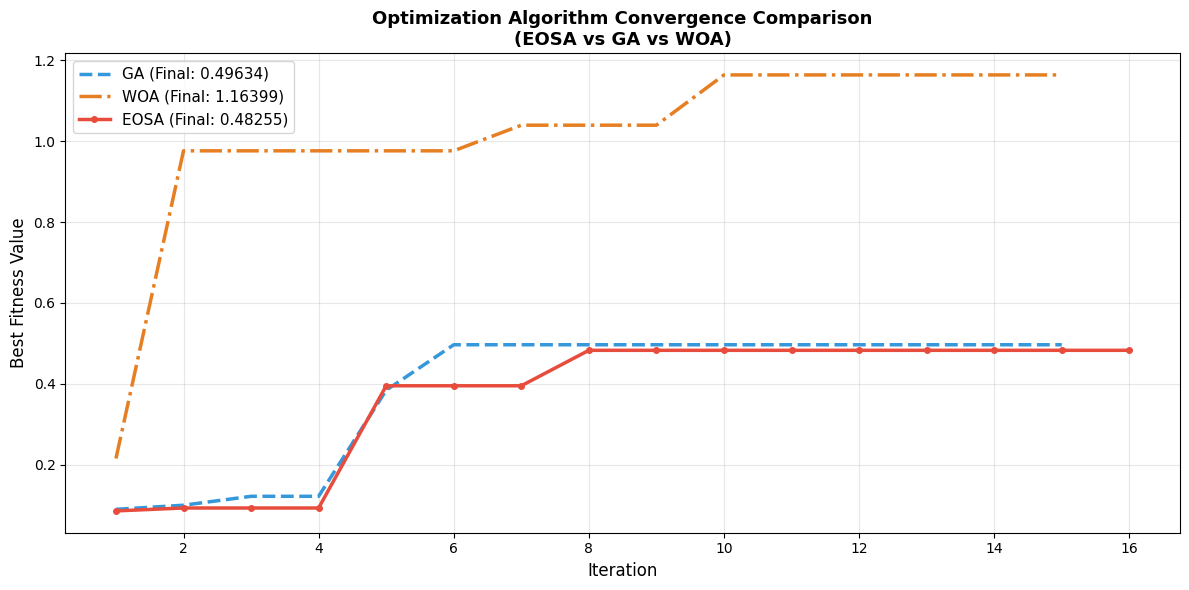

Convergence comparison saved ✓


In [15]:
# ============================================================
# CHUNK 14: PERFORMANCE COMPARISON PLOTS FOR PAPER
# ============================================================

def plot_metrics_comparison(all_metrics, model_names, classes, save=True):
    """Bar charts comparing all metrics across models"""
    
    metrics_overall = ['accuracy', 'kappa', 'overall_precision', 
                       'overall_recall', 'overall_f1', 'overall_specificity', 
                       'overall_sensitivity']
    metric_labels = ['Accuracy', 'Cohen Kappa', 'Precision', 
                     'Recall', 'F1 Score', 'Specificity', 'Sensitivity']
    
    n_metrics = len(metrics_overall)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    colors = ['#95a5a6', '#3498db', '#e67e22', '#e74c3c']
    
    for idx, (metric_key, metric_label) in enumerate(zip(metrics_overall, metric_labels)):
        ax = axes[idx]
        values = [all_metrics[name][metric_key] for name in model_names]
        
        bars = ax.bar(model_names, values, color=colors, alpha=0.85, 
                     edgecolor='black', linewidth=1)
        
        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
                   f'{val:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        ax.set_title(metric_label, fontsize=12, fontweight='bold')
        ax.set_ylim([0, 1.15])
        ax.set_ylabel('Score', fontsize=10)
        ax.grid(axis='y', alpha=0.3)
        ax.tick_params(axis='x', rotation=15)
        
        # Highlight best
        best_idx = np.argmax(values)
        bars[best_idx].set_edgecolor('gold')
        bars[best_idx].set_linewidth(3)
    
    # Remove empty subplot
    axes[-1].set_visible(False)
    
    plt.suptitle('Performance Metrics Comparison - All Models', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    if save:
        plt.savefig('metrics_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Metrics comparison plot saved ✓")


def plot_per_class_metrics(all_metrics, model_names, classes, save=True):
    """Per-class metrics comparison"""
    metrics = ['sensitivity', 'specificity', 'precision', 'f1']
    metric_labels = ['Sensitivity (Recall)', 'Specificity', 'Precision', 'F1 Score']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    x = np.arange(len(classes))
    width = 0.2
    colors = ['#95a5a6', '#3498db', '#e67e22', '#e74c3c']
    
    for ax_idx, (metric, label) in enumerate(zip(metrics, metric_labels)):
        ax = axes[ax_idx]
        
        for i, (name, color) in enumerate(zip(model_names, colors)):
            values = [all_metrics[name][metric][cls] for cls in classes]
            bars = ax.bar(x + i*width, values, width, label=name, 
                         color=color, alpha=0.85, edgecolor='black', linewidth=0.8)
        
        ax.set_title(f'Per-Class {label}', fontsize=12, fontweight='bold')
        ax.set_xticks(x + width * (len(model_names)-1) / 2)
        ax.set_xticklabels(classes, fontsize=11)
        ax.set_ylabel(label, fontsize=10)
        ax.set_ylim([0, 1.15])
        ax.legend(fontsize=9)
        ax.grid(axis='y', alpha=0.3)
    
    plt.suptitle('Per-Class Performance Metrics - All Models', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    if save:
        plt.savefig('per_class_metrics.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Per-class metrics plot saved ✓")


def plot_convergence_comparison(fitness_histories, model_names, save=True):
    """Compare EOSA convergence with other optimizers"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    all_histories = {
        'GA': ga_fitness_history,
        'WOA': woa_fitness_history,
        'EOSA': eosa_fitness_history
    }
    
    colors = {'GA': '#3498db', 'WOA': '#e67e22', 'EOSA': '#e74c3c'}
    linestyles = {'GA': '--', 'WOA': '-.', 'EOSA': '-'}
    
    for name, hist in all_histories.items():
        ax.plot(range(1, len(hist)+1), hist, 
               color=colors[name], linewidth=2.5,
               linestyle=linestyles[name],
               label=f'{name} (Final: {hist[-1]:.5f})',
               marker='o' if name == 'EOSA' else None,
               markersize=4)
    
    ax.set_xlabel('Iteration', fontsize=12)
    ax.set_ylabel('Best Fitness Value', fontsize=12)
    ax.set_title('Optimization Algorithm Convergence Comparison\n(EOSA vs GA vs WOA)',
                fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save:
        plt.savefig('convergence_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Convergence comparison saved ✓")


# Run all comparison plots
plot_metrics_comparison(all_metrics, list(models_dict.keys()), cfg.CLASSES)
plot_per_class_metrics(all_metrics, list(models_dict.keys()), cfg.CLASSES)
plot_convergence_comparison(None, None)


Running 5-Fold Cross Validation on EOSA-CNN

--- Fold 1/5 ---


2026-02-21 17:32:47.457564: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 17:32:47.596742: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


Fold 1 Accuracy: 0.1091 | F1: 0.0656

--- Fold 2/5 ---
Fold 2 Accuracy: 0.5136 | F1: 0.2262

--- Fold 3/5 ---


2026-02-21 17:34:01.119563: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 17:34:01.258980: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


Fold 3 Accuracy: 0.1096 | F1: 0.0658

--- Fold 4/5 ---
Fold 4 Accuracy: 0.1096 | F1: 0.0658

--- Fold 5/5 ---
Fold 5 Accuracy: 0.1096 | F1: 0.0658


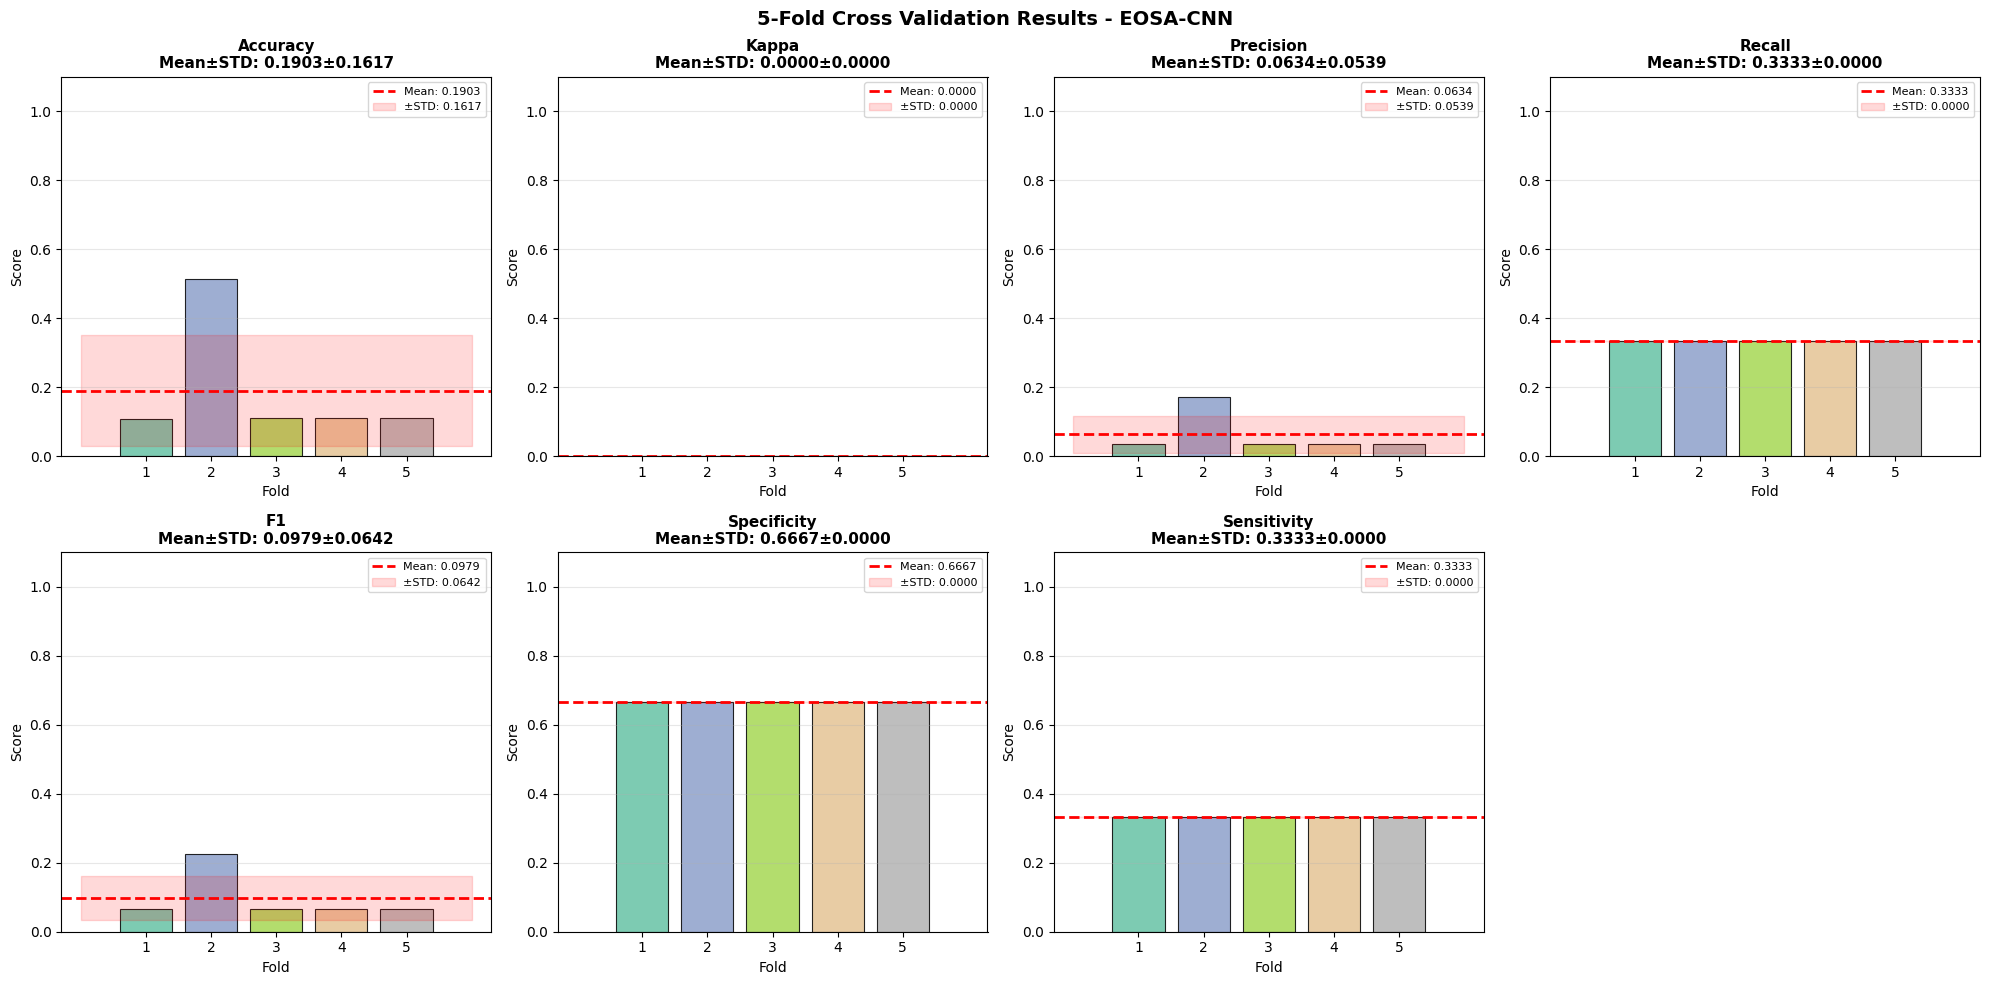

K-fold results plot saved ✓

K-FOLD CROSS VALIDATION SUMMARY
Metric              Mean      STD      Min      Max   Median
------------------------------------------------------------
accuracy          0.1903   0.1617   0.1091   0.5136   0.1096
kappa             0.0000   0.0000   0.0000   0.0000   0.0000
precision         0.0634   0.0539   0.0364   0.1712   0.0365
recall            0.3333   0.0000   0.3333   0.3333   0.3333
f1                0.0979   0.0642   0.0656   0.2262   0.0658
specificity       0.6667   0.0000   0.6667   0.6667   0.6667
sensitivity       0.3333   0.0000   0.3333   0.3333   0.3333


In [16]:
# ============================================================
# CHUNK 15: K-FOLD CROSS VALIDATION & FINAL PAPER TABLES
# ============================================================

def run_kfold_validation(X, y, cfg, n_splits=5):
    """K-Fold cross validation for EOSA-CNN"""
    print(f"\n{'='*60}")
    print(f"Running {n_splits}-Fold Cross Validation on EOSA-CNN")
    print("="*60)
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    fold_metrics = {
        'accuracy': [], 'kappa': [], 'precision': [],
        'recall': [], 'f1': [], 'specificity': [], 'sensitivity': []
    }
    
    y_cat = to_categorical(y, cfg.NUM_CLASSES)
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n--- Fold {fold+1}/{n_splits} ---")
        
        X_tr, X_vl = X[train_idx], X[val_idx]
        y_tr, y_vl = y_cat[train_idx], y_cat[val_idx]
        y_vl_raw = y[val_idx]
        
        # Build and train model
        model = build_cnn_from_scratch(cfg.INPUT_SHAPE, cfg.NUM_CLASSES, cfg.DROPOUT_RATE)
        model = compile_model(model)
        
        model.fit(X_tr, y_tr, validation_data=(X_vl, y_vl),
                 epochs=20, batch_size=cfg.BATCH_SIZE, verbose=0,
                 callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])
        
        # Metrics
        m = compute_all_metrics(model, X_vl, y_vl_raw, y_vl, cfg.CLASSES)
        
        fold_metrics['accuracy'].append(m['accuracy'])
        fold_metrics['kappa'].append(m['kappa'])
        fold_metrics['precision'].append(m['overall_precision'])
        fold_metrics['recall'].append(m['overall_recall'])
        fold_metrics['f1'].append(m['overall_f1'])
        fold_metrics['specificity'].append(m['overall_specificity'])
        fold_metrics['sensitivity'].append(m['overall_sensitivity'])
        
        print(f"Fold {fold+1} Accuracy: {m['accuracy']:.4f} | F1: {m['overall_f1']:.4f}")
        
        keras.backend.clear_session()
    
    return fold_metrics


def plot_kfold_results(fold_metrics, n_splits=5, save=True):
    """Visualize K-fold cross validation results"""
    metrics = list(fold_metrics.keys())
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    colors = plt.cm.Set2(np.linspace(0, 1, n_splits))
    
    for ax_idx, metric in enumerate(metrics):
        ax = axes[ax_idx]
        values = fold_metrics[metric]
        
        # Bar per fold
        ax.bar(range(1, n_splits+1), values, color=colors, 
               edgecolor='black', linewidth=0.8, alpha=0.85)
        
        # Mean and std lines
        mean_val = np.mean(values)
        std_val = np.std(values)
        ax.axhline(y=mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.4f}')
        ax.fill_between(range(0, n_splits+2), 
                       mean_val-std_val, mean_val+std_val, 
                       alpha=0.15, color='red', label=f'±STD: {std_val:.4f}')
        
        ax.set_title(f'{metric.capitalize()}\nMean±STD: {mean_val:.4f}±{std_val:.4f}', 
                    fontsize=11, fontweight='bold')
        ax.set_xlabel('Fold', fontsize=10)
        ax.set_ylabel('Score', fontsize=10)
        ax.set_xticks(range(1, n_splits+1))
        ax.set_ylim([0, 1.1])
        ax.legend(fontsize=8)
        ax.grid(axis='y', alpha=0.3)
    
    axes[-1].set_visible(False)
    
    plt.suptitle(f'{n_splits}-Fold Cross Validation Results - EOSA-CNN', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    if save:
        plt.savefig('kfold_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("K-fold results plot saved ✓")


# Run K-Fold
fold_metrics = run_kfold_validation(X, y, cfg, n_splits=5)
plot_kfold_results(fold_metrics)

# Print K-fold summary table
print("\n" + "="*60)
print("K-FOLD CROSS VALIDATION SUMMARY")
print("="*60)
print(f"{'Metric':<15} {'Mean':>8} {'STD':>8} {'Min':>8} {'Max':>8} {'Median':>8}")
print("-"*60)
for metric, values in fold_metrics.items():
    print(f"{metric:<15} {np.mean(values):>8.4f} {np.std(values):>8.4f} "
          f"{np.min(values):>8.4f} {np.max(values):>8.4f} {np.median(values):>8.4f}")

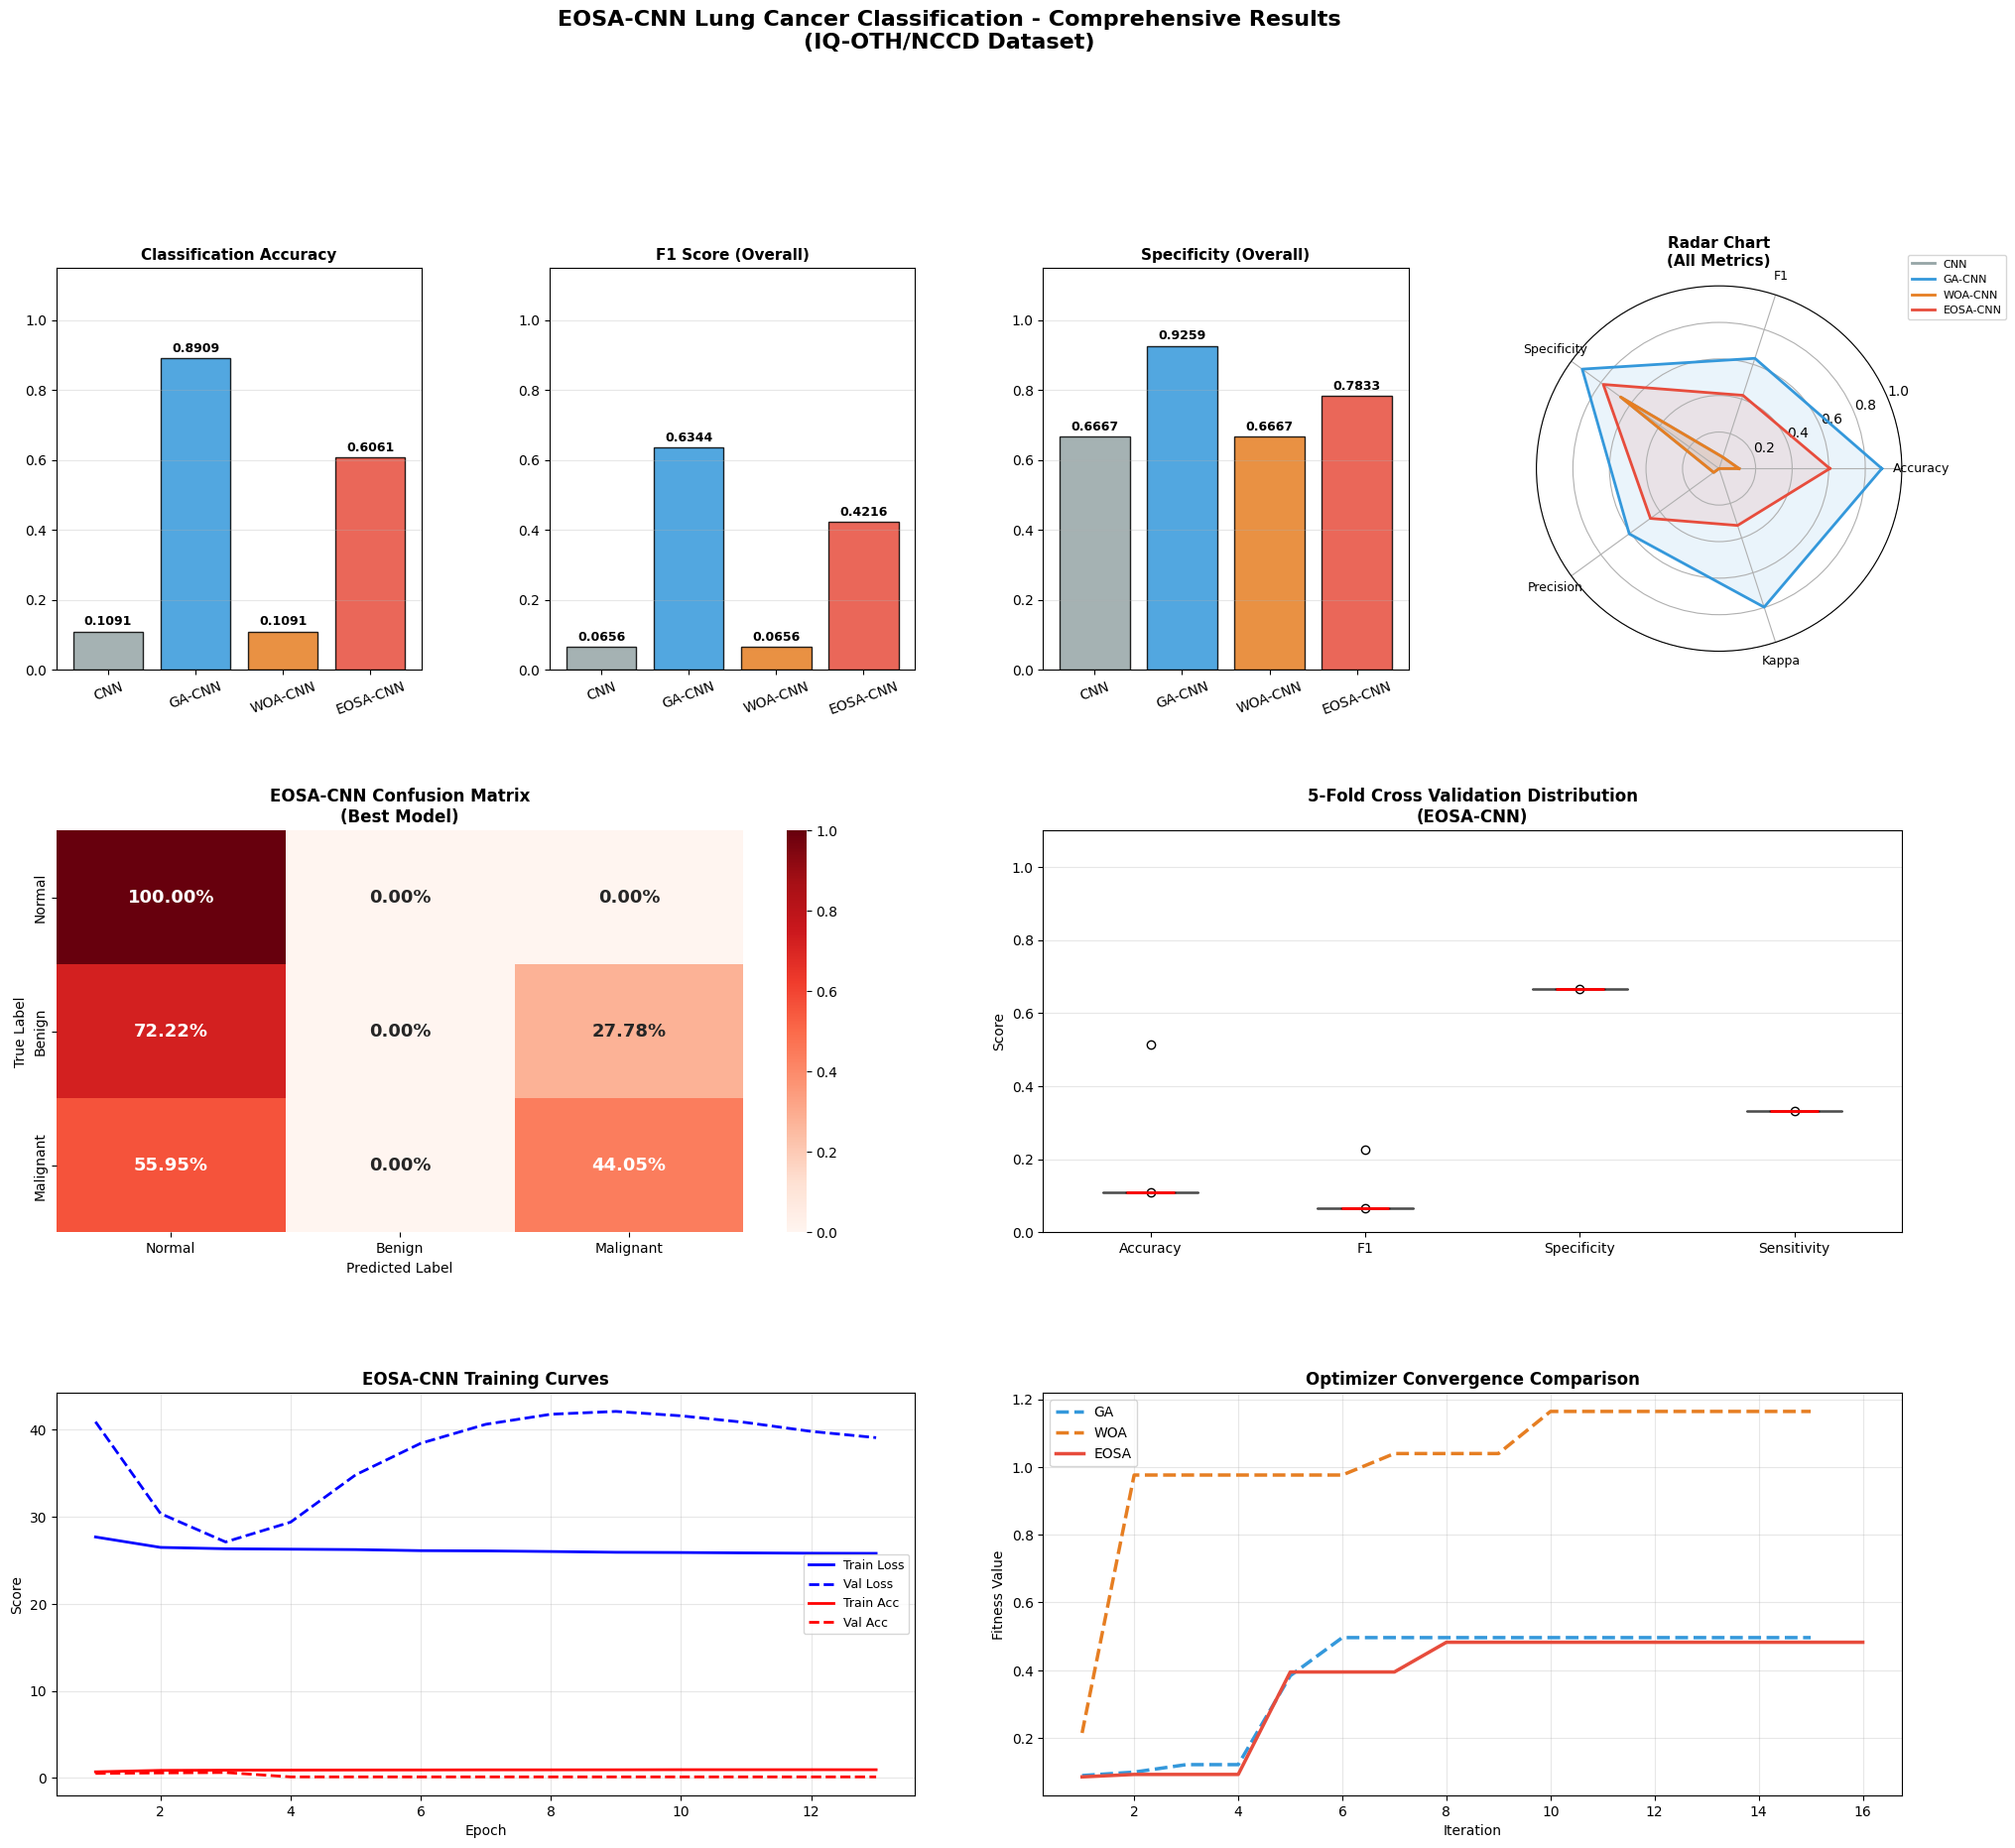


Final comprehensive figure saved ✓

Results table saved to CSV ✓
   Model  Accuracy    Kappa  Precision   Recall  F1_Score  Specificity  Sensitivity
     CNN  0.109091 0.000000   0.036364 0.333333  0.065574     0.666667     0.333333
  GA-CNN  0.890909 0.797794   0.607843 0.666667  0.634409     0.925926     0.666667
 WOA-CNN  0.109091 0.000000   0.036364 0.333333  0.065574     0.666667     0.333333
EOSA-CNN  0.606061 0.327502   0.464383 0.480159  0.421574     0.783345     0.480159

ALL DONE! Files saved to /kaggle/working/
Generated files:
  - class_distribution.png
  - sample_images.png
  - preprocessing_pipeline.png
  - training_curves.png
  - overfitting_analysis.png
  - confusion_matrices.png
  - roc_curves.png
  - metrics_comparison.png
  - per_class_metrics.png
  - convergence_comparison.png
  - eosa_convergence.png
  - kfold_results.png
  - final_comprehensive_results.png
  - results_table.csv


In [17]:
# ============================================================
# CHUNK 16: FINAL COMPREHENSIVE REPORT FIGURE FOR PAPER
# ============================================================

def create_final_summary_figure(all_metrics, model_names, fold_metrics, save=True):
    """Create one comprehensive summary figure for paper"""
    
    fig = plt.figure(figsize=(24, 20))
    gs = gridspec.GridSpec(3, 4, figure=fig, hspace=0.4, wspace=0.35)
    
    colors_model = ['#95a5a6', '#3498db', '#e67e22', '#e74c3c']
    
    # 1. Accuracy comparison
    ax1 = fig.add_subplot(gs[0, 0])
    accs = [all_metrics[n]['accuracy'] for n in model_names]
    bars = ax1.bar(model_names, accs, color=colors_model, alpha=0.85, edgecolor='black')
    for bar, v in zip(bars, accs):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height()+0.01,
                f'{v:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    ax1.set_title('Classification Accuracy', fontweight='bold', fontsize=11)
    ax1.set_ylim([0, 1.15])
    ax1.grid(axis='y', alpha=0.3)
    ax1.tick_params(axis='x', rotation=20)
    
    # 2. F1 Score comparison
    ax2 = fig.add_subplot(gs[0, 1])
    f1s = [all_metrics[n]['overall_f1'] for n in model_names]
    bars = ax2.bar(model_names, f1s, color=colors_model, alpha=0.85, edgecolor='black')
    for bar, v in zip(bars, f1s):
        ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height()+0.01,
                f'{v:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    ax2.set_title('F1 Score (Overall)', fontweight='bold', fontsize=11)
    ax2.set_ylim([0, 1.15])
    ax2.grid(axis='y', alpha=0.3)
    ax2.tick_params(axis='x', rotation=20)
    
    # 3. Specificity comparison
    ax3 = fig.add_subplot(gs[0, 2])
    specs = [all_metrics[n]['overall_specificity'] for n in model_names]
    bars = ax3.bar(model_names, specs, color=colors_model, alpha=0.85, edgecolor='black')
    for bar, v in zip(bars, specs):
        ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height()+0.01,
                f'{v:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    ax3.set_title('Specificity (Overall)', fontweight='bold', fontsize=11)
    ax3.set_ylim([0, 1.15])
    ax3.grid(axis='y', alpha=0.3)
    ax3.tick_params(axis='x', rotation=20)
    
    # 4. Radar chart
    ax4 = fig.add_subplot(gs[0, 3], polar=True)
    metric_keys = ['accuracy', 'overall_f1', 'overall_specificity', 
                   'overall_precision', 'kappa']
    metric_labels_radar = ['Accuracy', 'F1', 'Specificity', 'Precision', 'Kappa']
    N = len(metric_labels_radar)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    for i, (name, color) in enumerate(zip(model_names, colors_model)):
        values = [all_metrics[name][k] for k in metric_keys]
        values += values[:1]
        ax4.plot(angles, values, color=color, linewidth=2, label=name)
        ax4.fill(angles, values, color=color, alpha=0.1)
    
    ax4.set_xticks(angles[:-1])
    ax4.set_xticklabels(metric_labels_radar, fontsize=9)
    ax4.set_ylim([0, 1])
    ax4.set_title('Radar Chart\n(All Metrics)', fontweight='bold', fontsize=11, pad=15)
    ax4.legend(fontsize=8, loc='upper right', bbox_to_anchor=(1.3, 1.1))
    
    # 5. EOSA Confusion Matrix
    ax5 = fig.add_subplot(gs[1, 0:2])
    cm = all_metrics['EOSA-CNN']['confusion_matrix']
    cm_norm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Reds',
               xticklabels=['Normal', 'Benign', 'Malignant'],
               yticklabels=['Normal', 'Benign', 'Malignant'],
               ax=ax5, annot_kws={'size': 13, 'weight': 'bold'})
    ax5.set_title('EOSA-CNN Confusion Matrix\n(Best Model)', fontweight='bold', fontsize=12)
    ax5.set_ylabel('True Label')
    ax5.set_xlabel('Predicted Label')
    
    # 6. K-fold box plot
    ax6 = fig.add_subplot(gs[1, 2:4])
    kfold_data = [fold_metrics[m] for m in ['accuracy', 'f1', 'specificity', 'sensitivity']]
    kfold_labels = ['Accuracy', 'F1', 'Specificity', 'Sensitivity']
    
    bp = ax6.boxplot(kfold_data, labels=kfold_labels, patch_artist=True,
                    notch=True, medianprops={'color': 'red', 'linewidth': 2})
    kfold_colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    for patch, color in zip(bp['boxes'], kfold_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax6.set_title('5-Fold Cross Validation Distribution\n(EOSA-CNN)', fontweight='bold', fontsize=12)
    ax6.set_ylabel('Score')
    ax6.set_ylim([0, 1.1])
    ax6.grid(axis='y', alpha=0.3)
    
    # 7. Training curves EOSA-CNN
    ax7 = fig.add_subplot(gs[2, 0:2])
    h = history_eosa.history
    epochs = range(1, len(h['loss'])+1)
    ax7.plot(epochs, h['loss'], 'b-', linewidth=2, label='Train Loss')
    ax7.plot(epochs, h['val_loss'], 'b--', linewidth=2, label='Val Loss')
    ax7.plot(epochs, h['accuracy'], 'r-', linewidth=2, label='Train Acc')
    ax7.plot(epochs, h['val_accuracy'], 'r--', linewidth=2, label='Val Acc')
    ax7.set_title('EOSA-CNN Training Curves', fontweight='bold', fontsize=12)
    ax7.set_xlabel('Epoch')
    ax7.set_ylabel('Score')
    ax7.legend(fontsize=9)
    ax7.grid(True, alpha=0.3)
    
    # 8. EOSA convergence
    ax8 = fig.add_subplot(gs[2, 2:4])
    all_conv = {'GA': ga_fitness_history, 'WOA': woa_fitness_history, 'EOSA': eosa_fitness_history}
    conv_colors = {'GA': '#3498db', 'WOA': '#e67e22', 'EOSA': '#e74c3c'}
    for name, hist in all_conv.items():
        ax8.plot(range(1, len(hist)+1), hist, 
                color=conv_colors[name], linewidth=2.5, label=name,
                linestyle='-' if name=='EOSA' else '--')
    ax8.set_title('Optimizer Convergence Comparison', fontweight='bold', fontsize=12)
    ax8.set_xlabel('Iteration')
    ax8.set_ylabel('Fitness Value')
    ax8.legend(fontsize=10)
    ax8.grid(True, alpha=0.3)
    
    plt.suptitle('EOSA-CNN Lung Cancer Classification - Comprehensive Results\n(IQ-OTH/NCCD Dataset)', 
                 fontsize=16, fontweight='bold', y=1.01)
    
    if save:
        plt.savefig('final_comprehensive_results.png', dpi=200, bbox_inches='tight')
    plt.show()
    print("\nFinal comprehensive figure saved ✓")


create_final_summary_figure(all_metrics, list(models_dict.keys()), fold_metrics)

# Save metrics to CSV for paper
results_df = pd.DataFrame({
    'Model': list(models_dict.keys()),
    'Accuracy': [all_metrics[n]['accuracy'] for n in models_dict.keys()],
    'Kappa': [all_metrics[n]['kappa'] for n in models_dict.keys()],
    'Precision': [all_metrics[n]['overall_precision'] for n in models_dict.keys()],
    'Recall': [all_metrics[n]['overall_recall'] for n in models_dict.keys()],
    'F1_Score': [all_metrics[n]['overall_f1'] for n in models_dict.keys()],
    'Specificity': [all_metrics[n]['overall_specificity'] for n in models_dict.keys()],
    'Sensitivity': [all_metrics[n]['overall_sensitivity'] for n in models_dict.keys()],
})
results_df.to_csv('/kaggle/working/results_table.csv', index=False)
print("\nResults table saved to CSV ✓")
print(results_df.to_string(index=False))

print("\n" + "="*60)
print("ALL DONE! Files saved to /kaggle/working/")
print("="*60)
print("Generated files:")
print("  - class_distribution.png")
print("  - sample_images.png")
print("  - preprocessing_pipeline.png")
print("  - training_curves.png")
print("  - overfitting_analysis.png")
print("  - confusion_matrices.png")
print("  - roc_curves.png")
print("  - metrics_comparison.png")
print("  - per_class_metrics.png")
print("  - convergence_comparison.png")
print("  - eosa_convergence.png")
print("  - kfold_results.png")
print("  - final_comprehensive_results.png")
print("  - results_table.csv")